# 06 — Results & Visualization
UMAPs, QC overlays, cluster annotation, and optional enrichment.

**Input**: `data/processed/ssc_skin_scvi.h5ad`
**Output**: figures in `results/figures/`, tables in `results/tables/`

## 0.1) Notebook header: paths, logging, and outputs


In [1]:
import  os,  sys,  json,  platform,  random,  warnings

from  pathlib  import  Path

import  numpy  as  np

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="louvain")

# Repro/verbosity.
SEED = 42

np.random.seed(SEED); random.seed(SEED)

# 'Find' 'repo root' by 'locating' a 'top-level "data" folder'.
here = Path.cwd()
repo = None

for  p  in  [here] + list(here.parents):
    if  (p / "data").is_dir():
        repo = p; break

if  repo  is  None:
    raise  RuntimeError("Couldn't find repo root containing 'data/'." +
                        "Start the notebook from within the repo.")

os.chdir(repo)
print("Working dir:", Path.cwd())

# 'Output dirs'.
FIGDIR = Path("results/figures")
FIGDIR.mkdir(parents=True, exist_ok=True)

TABDIR = Path("results/tables")
TABDIR.mkdir(parents=True, exist_ok=True)

# 'Environment capture' (printed. saved later.)
ENV_INFO = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
}
print(json.dumps(ENV_INFO, indent=2))


Working dir: /home/glen/scleroderma-scvi
{
  "python": "3.10.18",
  "platform": "Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.35"
}


## 0.2) Scanpy load & sanity

In [30]:
import scanpy as sc
import numpy as np
import pandas as pd
from pathlib import Path

# 1) Load current (scVI) object
adata_path = Path("data/processed/ssc_skin_scvi.h5ad")

if  not adata_path.exists():
    # 'Fallbacks' you might have 'used earlier'.
    cands = [
        Path("data/processed/ssc_skin_basic.h5ad"),
        Path("data/processed/ssc_skin.h5ad"),
    ]

    for  c  in  cands:

        if c.exists():
            adata_path = c; break

assert  adata_path.exists(),f"Missing {adata_path}. Run src/modeling.py first."

adata = sc.read_h5ad(adata_path)

# Ensure we have clusters to label
assert "leiden" in adata.obs, "Missing leiden clusters. Run de_analysis.py first."

# Only (re)compute suggested labels if not already labeled
if "cell_type" not in adata.obs:
    print("No `cell_type` found – proposing labels from marker panels...")

    # 1) Define marker panels (edit as you like; only genes present are used)
    panels = {
        "Keratinocytes (basal)": ["KRT14","KRT5","KRT6A","KRT6B"],
        "Keratinocytes (suprabasal)": ["KRT1","KRT10","IVL","SPRR1B"],
        "Fibroblasts": ["COL1A1","COL1A2","DCN","LUM","PDGFRA","FBLN1"],
        "Myofibroblasts": ["ACTA2","TAGLN","MYL9","COL1A1","COL1A2"],
        "Endothelial": ["PECAM1","VWF","CLDN5","KDR","ENG"],
        "Lymphatic endothelium": ["PROX1","PDPN","LYVE1"],
        "Pericyte/SMC": ["RGS5","PDGFRB","MCAM","ACTA2"],
        "T cells (naive/memory)": ["CD3D","CD3E","TRAC","IL7R","CCR7"],
        "T/NK cytotoxic": ["NKG7","GNLY","PRF1","GZMB","KLRD1"],
        "B cells": ["MS4A1","CD79A","CD79B","CD74","BANK1"],
        "Plasma cells": ["MZB1","XBP1","PRDM1","IGHG1","SDC1"],
        "Myeloid (mono/mac)": ["LYZ","S100A8","S100A9","FCGR3A","CTSS"],
        "Dendritic cells (cDC2)": ["CD1C","FCER1A","IRF4"],
        "cDC1 / pDC mix": ["CLEC9A","XCR1","GZMB","LILRA4"],
        "Mast cells": ["TPSAB1","CPA3","KIT"],
        "Low-quality / ribosomal": ["RPS3","RPLP0","RPL13","RPSA"],
        "Low-quality / mitochondrial": ["MT-CO1","MT-ND1","MT-CYB","MT-ND2"],
    }

    # Map marker symbols -> current var_names via var['gene_symbol'] (robust to Ensembl var_names)
    from collections import defaultdict
    def map_symbols_to_varnames(adata, symbols):
        symbols = [str(g).upper() for g in symbols]
        if "gene_symbol" in adata.var.columns:
            sym_col = adata.var["gene_symbol"].astype(str).str.upper()
            bucket = defaultdict(list)
            for vname, sym in zip(adata.var_names, sym_col):
                bucket[sym].append(vname)  # keep all matches (duplicates ok)
            out = []
            for s in symbols:
                out.extend(bucket.get(s, []))
            # de-duplicate while preserving order
            seen = set(); out = [x for x in out if not (x in seen or seen.add(x))]
            return out
        else:
            # assume var_names already are symbols
            vn_set = set(adata.var_names)
            return [g for g in symbols if g in vn_set]

    # Build mapped panels in current var_name space
    panels_mapped = {}
    for k, genes in panels.items():
        matched = map_symbols_to_varnames(adata, genes)
        if matched:
            panels_mapped[k] = matched

    if not panels_mapped:
        raise ValueError("No panel genes matched var_names or var['gene_symbol'].")

    # 2) Compute per-cell scores for each panel using mapped var_names
    for name, gene_vnames in panels_mapped.items():
        sc.tl.score_genes(adata, gene_list=gene_vnames, score_name=f"score__{name}", use_raw=False)
    
    # 3) Aggregate to clusters and z-score across clusters (so panels are comparable)
    groupby = "leiden"
    score_cols = [c for c in adata.obs.columns if c.startswith("score__")]

    # NEW: guard against empty panels (no marker genes present)
    if not score_cols:
        raise ValueError("None of the marker genes are present in adata.var_names; panels are empty.")

    S = adata.obs.groupby(groupby)[score_cols].median()
    # NEW: robust z-score (avoid divide-by-zero; fill NaNs with 0)
    std = S.std(ddof=0).replace(0, np.nan)
    Z = ((S - S.mean()) / std).fillna(0.0)
    # NEW: make panel names pretty for labeling (drop the 'score__' prefix)
    Z.columns = [c.replace("score__", "") for c in Z.columns]

    # 4) QC overrides (use counts-based metrics if you saved them)
    qc_cols = [c for c in ["pct_counts_mt","pct_counts_ribo","frac_counts_ribo"] if c in adata.obs]
    qc = adata.obs.groupby(groupby)[qc_cols].median() if qc_cols else pd.DataFrame(index=S.index)
    
    # thresholds (tweak as needed)
    MT_HI = 7.5          # percent mito
    RIBO_HI = 25.0       # percent ribo if you have pct_counts_ribo; otherwise ignore
    
    overrides = pd.Series(index=S.index, dtype="object")
    if "pct_counts_mt" in qc:
        overrides[qc["pct_counts_mt"] >= MT_HI] = "Low-quality / mitochondrial"

    if "pct_counts_ribo" in qc:
        overrides[qc["pct_counts_ribo"] >= RIBO_HI] = "Low-quality / ribosomal"
    elif "frac_counts_ribo" in qc:
        overrides[qc["frac_counts_ribo"] >= (RIBO_HI / 100.0)] = "Low-quality / ribosomal"        
    
    # 5) Suggest label = highest z-score panel, with a simple confidence margin
    top = Z.idxmax(axis=1)
    margin = (Z.max(axis=1) - Z.apply(lambda r: r.nlargest(2).iloc[-1] if (r > -np.inf).sum() > 1 else np.nan, axis=1))
    suggest = pd.DataFrame({
        "suggested": top,
        "margin": margin.round(3),
    }, index=Z.index)
    
    # apply QC overrides where present
    mask_ovr = overrides.notna()
    suggest.loc[mask_ovr, "suggested"] = overrides[mask_ovr]
    
    # 6) Inspect suggestions
    print("\nSuggested labels by cluster (with margin):")
    print(suggest.sort_index().to_string())
    
    # 7) (Optional) show top 5 markers per cluster to sanity-check
    # NEW: recompute RGG only if missing OR computed for a different groupby
    need_rgg = (
        "rank_genes_groups" not in adata.uns
        or adata.uns["rank_genes_groups"].get("params", {}).get("groupby") != groupby
    )
    if need_rgg:
        sc.tl.rank_genes_groups(adata, groupby=groupby, method="wilcoxon", use_raw=False, layer=None)

    df_de = sc.get.rank_genes_groups_df(adata, group=None)
    print("\nTop5 markers per cluster:")
    print(df_de.groupby("group", sort=False).head(5)[["group","names","logfoldchanges","pvals_adj"]].to_string(index=False))
    
    # 8) Build a ready-to-paste map_labels dict from suggestions
    map_labels_auto = {str(k): v for k, v in suggest["suggested"].items()}
    print("\nmap_labels (auto):")
    print(map_labels_auto)
    # Record provenance and flag ambiguous clusters
    adata.uns.setdefault("labeling_provenance", {})

    adata.uns["labeling_provenance"].update({
        "panels_symbols": panels,                 # original symbols you provided
        "panels_varnames": panels_mapped,         # var-names actually used for scoring
        "suggest_table": suggest.to_dict(orient="index"),
        "qc_thresholds": {"pct_counts_mt": MT_HI, "pct_counts_ribo": RIBO_HI},
    })

    ambig = suggest[suggest["margin"] < 0.3].index.tolist()
    if ambig:
        print("Low-margin (ambiguous) clusters to inspect (<0.3):", ", ".join(map(str, ambig)))

    # Apply the suggestions
    
    leiden_str = adata.obs["leiden"].astype(str)
    adata.obs["cell_type"] = (
        leiden_str.map(map_labels_auto)
                  .fillna(leiden_str)
                  .astype("category")
    )
    # (Optional) save an annotated copy
    adata.write("data/processed/ssc_skin_scvi_annot.h5ad", compression="gzip")
else:
    print("`cell_type` already present – skipping auto-label proposal.")



No `cell_type` found – proposing labels from marker panels...
computing score 'score__Keratinocytes (basal)'
    finished: added
    'score__Keratinocytes (basal)', score of gene set (adata.obs).
    149 total control genes are used. (0:00:00)
computing score 'score__Keratinocytes (suprabasal)'
    finished: added
    'score__Keratinocytes (suprabasal)', score of gene set (adata.obs).
    149 total control genes are used. (0:00:00)
computing score 'score__Fibroblasts'
    finished: added
    'score__Fibroblasts', score of gene set (adata.obs).
    97 total control genes are used. (0:00:00)
computing score 'score__Myofibroblasts'
    finished: added
    'score__Myofibroblasts', score of gene set (adata.obs).
    47 total control genes are used. (0:00:00)
computing score 'score__Endothelial'
    finished: added
    'score__Endothelial', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'score__Lymphatic endothelium'
    finished: added
    'sc


Top vs runner-up per cluster:
                               top   topZ                runner_up  runnerZ  margin
leiden                                                                             
0                      Fibroblasts  4.270           Myofibroblasts    0.851   3.419
1       Keratinocytes (suprabasal)  3.989  Low-quality / ribosomal    1.220   2.769
2                     Pericyte/SMC  3.127           Myofibroblasts    1.965   1.162
3                      Endothelial  3.125                  B cells    1.644   1.481
4            Keratinocytes (basal)  1.912  Low-quality / ribosomal    1.612   0.300
5            Keratinocytes (basal)  2.056  Low-quality / ribosomal    1.300   0.756
6           T cells (naive/memory)  4.334  Low-quality / ribosomal    0.967   3.367
7               Myeloid (mono/mac)  4.059                  B cells    2.203   1.856
8          Low-quality / ribosomal  0.550             Plasma cells   -0.087   0.637
9                      Fibroblasts  0.288    

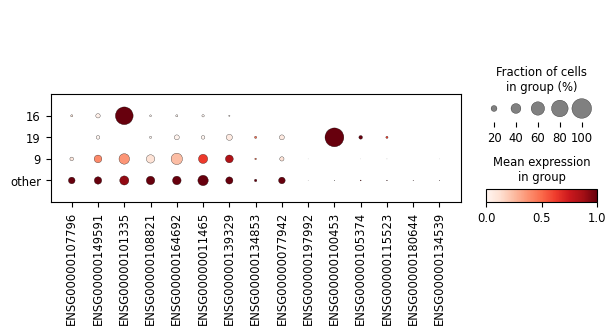

In [33]:
import numpy as np
import pandas as pd
import scanpy as sc

# Rebuild S/Z from the score columns we just created
groupby = "leiden"
score_cols = [c for c in adata.obs.columns if c.startswith("score__")]
S = adata.obs.groupby(groupby)[score_cols].median()
std = S.std(ddof=0).replace(0, np.nan)
Z = ((S - S.mean()) / std).fillna(0.0)
Z.columns = [c.replace("score__", "") for c in Z.columns]

# Top1 / Top2 summary per cluster
top1 = Z.idxmax(axis=1)
top1_val = Z.max(axis=1)
top2_val = Z.apply(lambda r: r.nlargest(2).iloc[-1] if (r.size >= 2) else np.nan, axis=1)
top2 = pd.Series(index=Z.index, dtype=object)
for i in Z.index:
    top2[i] = Z.columns[(Z.loc[i].values.argsort())[-2]] if Z.shape[1] >= 2 else np.nan

summary = pd.DataFrame({
    "top": top1,
    "topZ": top1_val.round(3),
    "runner_up": top2,
    "runnerZ": top2_val.round(3),
    "margin": (top1_val - top2_val).round(3),
}).sort_index()

print("\nTop vs runner-up per cluster:")
print(summary.to_string())

# Focus on ambiguous ones
ambig = summary.query("margin < 0.3").index.astype(str).tolist()
print("\nAmbiguous clusters (margin < 0.3):", ambig)

# Dotplot of markers for ambiguous clusters (union of top and runner-up panels)
if ambig:
    panels = {
        "Keratinocytes (basal)": ["KRT14","KRT5","KRT6A","KRT6B"],
        "Keratinocytes (suprabasal)": ["KRT1","KRT10","IVL","SPRR1B"],
        "Fibroblasts": ["COL1A1","COL1A2","DCN","LUM","PDGFRA","FBLN1"],
        "Myofibroblasts": ["ACTA2","TAGLN","MYL9","COL1A1","COL1A2"],
        "Endothelial": ["PECAM1","VWF","CLDN5","KDR","ENG"],
        "Lymphatic endothelium": ["PROX1","PDPN","LYVE1"],
        "Pericyte/SMC": ["RGS5","PDGFRB","MCAM","ACTA2"],
        "T cells (naive/memory)": ["CD3D","CD3E","TRAC","IL7R","CCR7"],
        "T/NK cytotoxic": ["NKG7","GNLY","PRF1","GZMB","KLRD1"],
        "B cells": ["MS4A1","CD79A","CD79B","CD74","BANK1"],
        "Plasma cells": ["MZB1","XBP1","PRDM1","IGHG1","SDC1"],
        "Myeloid (mono/mac)": ["LYZ","S100A8","S100A9","FCGR3A","CTSS"],
        "Dendritic cells (cDC2)": ["CD1C","FCER1A","IRF4"],
        "cDC1 / pDC mix": ["CLEC9A","XCR1","GZMB","LILRA4"],
        "Mast cells": ["TPSAB1","CPA3","KIT"],
        "Low-quality / ribosomal": ["RPS3","RPLP0","RPL13","RPSA"],
    }

    # Map symbols -> var_names (handles Ensembl in var_names)
    def map_symbols_to_varnames(adata, symbols):
        symbols = [str(g).upper() for g in symbols]
        if "gene_symbol" in adata.var.columns:
            sym = adata.var["gene_symbol"].astype(str).str.upper()
            m = {}
            for vname, s in zip(adata.var_names, sym):
                if s not in m: m[s] = vname
            return [m[g] for g in symbols if g in m]
        return [g for g in symbols if g in set(adata.var_names)]

    # Build a gene list covering top & runner-up panels for these clusters
    gs = []
    # Ensure summary index is string-typed to match `ambig`
    summary.index = summary.index.astype(str)
    for c in ambig:
        a = summary.loc[c, "top"]
        b = summary.loc[c, "runner_up"]
        for k in {a, b}:
            if k in panels:
                gs += map_symbols_to_varnames(adata, panels[k])
    genes_for_plot = pd.unique(gs).tolist()[:40]  # cap for readability

    # Make a temporary group that collapses non-ambiguous clusters (compare as strings)
    leiden_str = adata.obs["leiden"].astype(str)
    adata.obs["leiden_ambig"] = (
     leiden_str.where(leiden_str.isin(ambig), other="other").astype("category")
    )
    if genes_for_plot:
        sc.pl.dotplot(
            adata,
            var_names=genes_for_plot,
            groupby="leiden_ambig",
            standard_scale="var",
        )


## Targeted marker checks for each ambiguous pair


Focused panel means (ambiguous clusters only):
        Fibroblast_core  Myofibroblast_contractile  T_cytotoxic  cDC1_core  pDC_core
leiden                                                                              
9                 0.737                      0.612        0.006      0.183     0.158
16                0.049                      0.972        0.002      0.030     0.035
19                0.154                      0.043        0.452      2.200     1.739


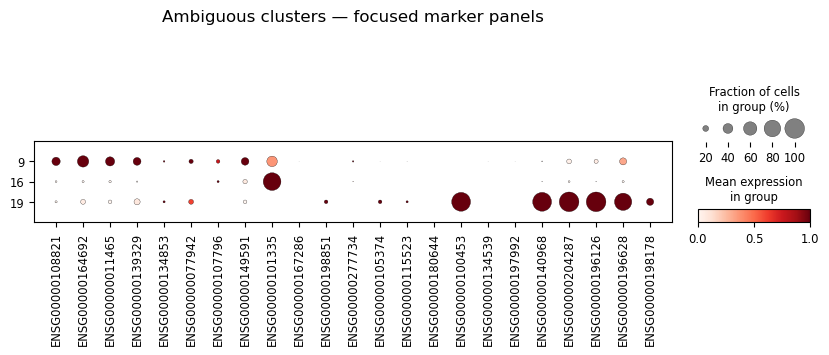

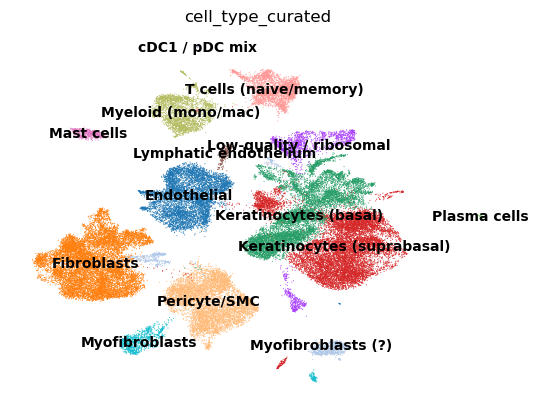

In [41]:
# Focused review & curation for ambiguous clusters (9,16,19)

import numpy as np
import pandas as pd
import scipy.sparse as sp
import scanpy as sc

# --- helper: map gene symbols -> current var_names (handles Ensembl var_names) ---
def _map_symbols(adata, symbols):
    syms = [str(g).upper() for g in symbols]
    if "gene_symbol" in adata.var.columns:
        sym = adata.var["gene_symbol"].astype(str).str.upper()
        lut = {s: v for v, s in zip(adata.var_names, sym)}
        return [lut[s] for s in syms if s in lut]
    # fallback: assume var_names already are symbols
    vset = set(adata.var_names)
    return [g for g in syms if g in vset]

# --- focused panels that separate your ambiguous pairs ---
panels_focus = {
    # 9 vs 16 (Fibroblast vs Myofibroblast)
    "Fibroblast_core": ["COL1A1","COL1A2","DCN","LUM","PDGFRA","FBLN1"],
    "Myofibroblast_contractile": ["ACTA2","TAGLN","MYL9"],
    # 19 (T/NK cytotoxic) vs DC
    "T_cytotoxic": ["CD3D","CD3E","TRAC","NKG7","GNLY","PRF1","GZMB","KLRD1"],
    "cDC1_core": ["CLEC9A","XCR1","IRF8","BATF3","HLA-DRA","HLA-DRB1"],
    "pDC_core": ["GZMB","LILRA4","IRF7","TCF4","CLEC4C"],
}

# Map panels to var_names present
panels_focus_mapped = {k: _map_symbols(adata, v) for k, v in panels_focus.items()}
panels_focus_mapped = {k: v for k, v in panels_focus_mapped.items() if v}  # keep non-empty

# Use the ambiguous set found earlier; or recompute quickly if needed
ambig = ['9','16','19']
leiden_str = adata.obs["leiden"].astype(str)
sub = adata[leiden_str.isin(ambig)].copy()

# --- compute per-cluster panel means on the per-cluster subset ---
def _panel_mean_adata(A, varnames):
    if not varnames:
        return np.nan
    X = A[:, varnames].X
    if sp.issparse(X):
        return float(np.nanmean(X.mean(axis=1).A1))
    return float(np.nanmean(np.asarray(X).mean(axis=1)))

rows = []
for cl in sorted(sub.obs["leiden"].unique(), key=lambda s: int(s)):
    A = sub[sub.obs["leiden"] == cl]
    row = {"leiden": cl}
    for name, genes in panels_focus_mapped.items():
        row[name] = _panel_mean_adata(A, genes)
    rows.append(row)

df_focus = pd.DataFrame(rows).set_index("leiden").round(3)
print("\nFocused panel means (ambiguous clusters only):")
print(df_focus.to_string())

# Optional visualization
genes_for_plot = []
for name in ["Fibroblast_core","Myofibroblast_contractile","T_cytotoxic","cDC1_core","pDC_core"]:
    genes_for_plot += panels_focus_mapped.get(name, [])
genes_for_plot = pd.unique(genes_for_plot).tolist()[:40]

if genes_for_plot:
    sub.obs["leiden"] = sub.obs["leiden"].astype("category")
    sc.pl.dotplot(
        sub,
        var_names=genes_for_plot,
        groupby="leiden",
        standard_scale="var",
        title="Ambiguous clusters — focused marker panels",
    )

# --- curate labels using simple, transparent rules ---
labels = adata.obs["cell_type"].astype(str).copy()

# 9 & 16: myofibroblast if contractile panel >= 0.8 * fibro panel, else fibro
for cl in ["9", "16"]:
    if cl in df_focus.index and {"Fibroblast_core","Myofibroblast_contractile"} <= set(df_focus.columns):
        fib = df_focus.loc[cl, "Fibroblast_core"]
        myo = df_focus.loc[cl, "Myofibroblast_contractile"]
        if not (np.isnan(fib) or np.isnan(myo)):
            ratio = (myo / fib) if fib > 0 else np.inf
            if ratio >= 0.8:
                # borderline if not overwhelmingly higher (add "(?)")
                labels[leiden_str == cl] = "Myofibroblasts" + (" (?)" if ratio < 1.2 else "")
            else:
                labels[leiden_str == cl] = "Fibroblasts"

# 19: pick T/NK vs DC by comparing T_cytotoxic to max(cDC1, pDC)
if "19" in df_focus.index:
    t_lineage = df_focus.loc["19", "T_cytotoxic"] if "T_cytotoxic" in df_focus.columns else np.nan
    cdc1 = df_focus.loc["19", "cDC1_core"] if "cDC1_core" in df_focus.columns else np.nan
    pdc  = df_focus.loc["19", "pDC_core"]  if "pDC_core"  in df_focus.columns else np.nan
    dc_lineage = np.nanmax([cdc1, pdc])
    if not (np.isnan(t_lineage) or np.isnan(dc_lineage)):
        if t_lineage >= dc_lineage + 0.15:
            labels[leiden_str == "19"] = "T/NK cytotoxic"
        elif dc_lineage >= t_lineage + 0.15:
            labels[leiden_str == "19"] = "cDC1 / pDC mix"
        else:
            labels[leiden_str == "19"] = "T/NK cytotoxic (?)"

adata.obs["cell_type_curated"] = labels.astype("category")

# Record these decisions in provenance
adata.uns.setdefault("labeling_provenance", {})
adata.uns["labeling_provenance"]["curation_notes"] = {
    "rules": {
        "fib_vs_myo": "myo >= 0.8 * fib -> Myofibroblasts (borderline gets ' (?)')",
        "t_vs_dc": "compare T_cytotoxic vs max(cDC1_core, pDC_core); margin 0.15",
    },
    "df_focus": df_focus.to_dict(orient="index"),
}

# Quick UMAP
sc.pl.umap(adata, color=["cell_type_curated"], legend_loc="on data", frameon=False, save="_celltype_curated.png")

# (Optional) persist annotated copy
# adata.write("data/processed/ssc_skin_scvi_annot_curated.h5ad", compression="gzip")


map_labels_final = {
    "0": "Fibroblasts",
    "1": "Keratinocytes (suprabasal)",
    "10": "Keratinocytes (suprabasal)",
    "11": "Myofibroblasts",
    "12": "Mast cells",
    "13": "Keratinocytes (basal)",
    "14": "Low-quality / ribosomal",
    "15": "Lymphatic endothelium",
    "16": "Myofibroblasts",
    "17": "Keratinocytes (suprabasal)",
    "18": "Plasma cells",
    "19": "cDC1 / pDC mix",
    "2": "Pericyte/SMC",
    "3": "Endothelial",
    "4": "Keratinocytes (basal)",
    "5": "Keratinocytes (basal)",
    "6": "T cells (naive/memory)",
    "7": "Myeloid (mono/mac)",
    "8": "Low-quality / ribosomal",
    "9": "Myofibroblasts (?)",
}


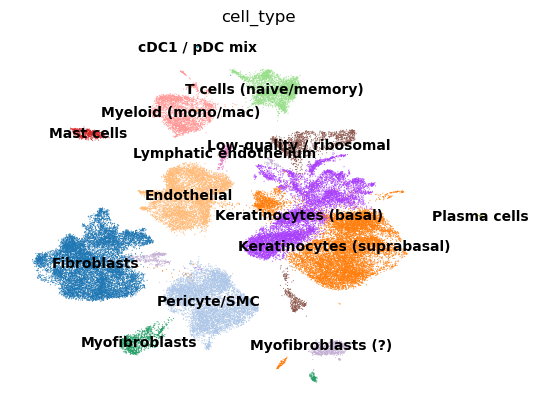

[saved] data/processed/ssc_skin_scvi_annot_curated.h5ad


In [43]:
import pandas as pd

# 1) Promote curated labels to `cell_type`
adata.obs["cell_type"] = adata.obs["cell_type_curated"].astype("category")

# 2) Build a clean, one-to-one mapping (cluster -> label)
tt = (
    adata.obs[["leiden", "cell_type"]]
    .copy()
    .astype({"leiden": "string", "cell_type": "string"})
    .drop_duplicates()
    .sort_values("leiden")
)
# If a cluster appears with multiple labels, pick the most frequent
if (tt.groupby("leiden")["cell_type"].nunique() > 1).any():
    tt = (
        adata.obs.groupby(["leiden","cell_type"]).size()
        .reset_index(name="n")
        .sort_values(["leiden","n"], ascending=[True, False])
        .drop_duplicates("leiden")
        .loc[:, ["leiden","cell_type"]]
        .astype("string")
        .sort_values("leiden")
    )

map_labels_final = dict(zip(tt["leiden"], tt["cell_type"]))
print("map_labels_final = {")
for k, v in map_labels_final.items():
    print(f'    "{k}": "{v}",')
print("}")

# 3) (Optional) order categories: mapping order + any remaining

# Build desired order from the mapping (dedupe while preserving order)
ordered = list(dict.fromkeys(map_labels_final.values()))

# Include any labels that exist in the column but weren't in the mapping
current = adata.obs["cell_type"].astype("category").cat.categories.tolist()
ordered_all = [c for c in ordered if pd.notna(c)] + [c for c in current if c not in ordered and pd.notna(c)]

# Apply as ordered categorical
adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")
adata.obs["cell_type"] = adata.obs["cell_type"].cat.set_categories(ordered_all, ordered=True)

# 4) Save annotated object + a couple of helper tables
adata.write("data/processed/ssc_skin_scvi_annot_curated.h5ad", compression="gzip")
adata.obs[["leiden","cell_type"]].drop_duplicates().sort_values("leiden").to_csv(
    "results/tables/leiden_to_celltype.csv", index=False
)
# margins table if you still have `summary` from earlier
try:
    summary.to_csv("results/tables/label_margins_by_cluster.csv")
except NameError:
    pass

# 5) Final UMAP
sc.pl.umap(adata, color=["cell_type"], legend_loc="on data", frameon=False, save="_celltype_final.png")
print("[saved] data/processed/ssc_skin_scvi_annot_curated.h5ad")


In [44]:
# Safe, optional sanity print
try:
    idx = ['9','16','19']
    present = [i for i in idx if 'df_focus' in globals() and i in df_focus.index.astype(str)]
    if present:
        display(df_focus.loc[present])
    else:
        print("Run the focused-panel curation cell first (no matching clusters yet).")
except Exception as e:
    print("Could not display df_focus subset:", e)


Fibroblast_core  Myofibroblast_contractile  T_cytotoxic  cDC1_core  \
leiden                                                                       
9                 0.737                      0.612        0.006      0.183   
16                0.049                      0.972        0.002      0.030   
19                0.154                      0.043        0.452      2.200   

        pDC_core  
leiden            
9          0.158  
16         0.035  
19         1.739

mt genes present: 2
count    56147.000000
mean         1.626801
std          1.597303
min          0.000000
25%          0.552595
50%          1.226693
75%          2.238806
max         22.000000
Name: pct_counts_mt, dtype: float64
leiden
12    2.941176
10    2.785537
5     2.433020
14    2.103240
11    1.902174
Name: pct_counts_mt, dtype: float32


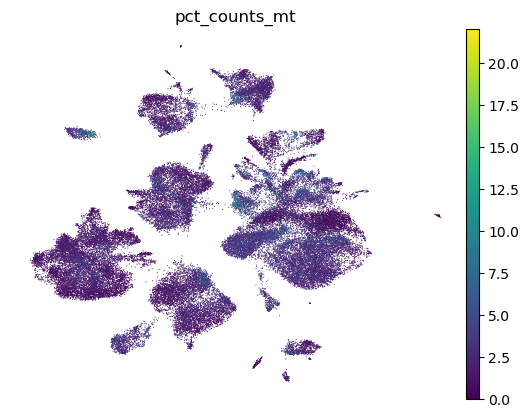

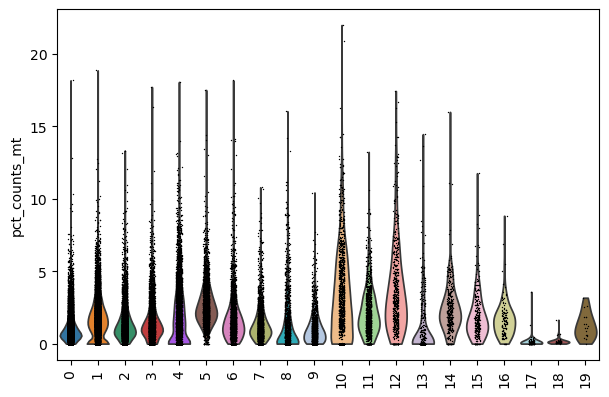

In [45]:
import numpy as np
import pandas as pd

# mt gene flag (optional)
if "mt" in adata.var:
    print("mt genes present:", int(np.asarray(adata.var["mt"]).sum()))
else:
    print("mt genes present: (no 'mt' flag in adata.var)")

# mito percentage summaries (optional)
if "pct_counts_mt" in adata.obs:
    print(adata.obs["pct_counts_mt"].describe())
    if "leiden" in adata.obs:
        print(
            adata.obs.groupby("leiden", observed=False)["pct_counts_mt"]
            .median()
            .sort_values(ascending=False)
            .head(5)
        )
else:
    print("No 'pct_counts_mt' in adata.obs (skip mito summaries).")

if "pct_counts_mt" in adata.obs:
    sc.pl.umap(adata, color=["pct_counts_mt"], frameon=False)
    if "leiden" in adata.obs:
        sc.pl.violin(adata, keys="pct_counts_mt", groupby="leiden", rotation=90)


## 0.3) QC metrics: ensure mito/ribo % exist

In [46]:
import pandas as pd
import scipy.sparse as sp

# Robust mito flag (prefer gene_symbol if present)
if "mt" not in adata.var.columns:
    names = (adata.var.get("gene_symbol", adata.var_names)).astype(str).str.upper()
    adata.var["mt"] = names.str.startswith(("MT-","MT.","MT_"))

# Choose a counts source for QC
_qc_layer = "counts" if "counts" in adata.layers else None

# Compute mito QC only if missing; prefer counts layer (or .raw fallback)
if any(k not in adata.obs.columns for k in ["n_genes_by_counts","total_counts","pct_counts_mt"]):
    if _qc_layer is not None:
        sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], layer=_qc_layer, inplace=True)
    elif adata.raw is not None:
        base = adata.raw.to_adata()
        sc.pp.calculate_qc_metrics(base, qc_vars=["mt"], inplace=True)
        for col in ["n_genes_by_counts","total_counts","pct_counts_mt"]:
            adata.obs[col] = base.obs[col].values
    else:
        # Fallback: use X (may be approximate if X is logged)
        print("WARNING: no counts layer/raw; mito QC from X may be approximate.")
        sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

# Ribosomal percentage from counts (RPS*/RPL*)
if "pct_counts_ribo" not in adata.obs.columns:
    # Build mask in the coordinate space used for counts
    if _qc_layer is not None:
        X = adata.layers["counts"]
        names_ref = adata.var_names
    elif adata.raw is not None:
        base = adata.raw.to_adata()
        X = base.X
        names_ref = base.var_names
    else:
        X = adata.X
        names_ref = adata.var_names
        print("WARNING: no counts layer/raw; ribosomal % from X may be approximate.")

    is_ribo = names_ref.astype(str).str.upper().str.startswith(("RPS","RPL")).values
    if is_ribo.any():
        if sp.issparse(X):
            ribo = X[:, is_ribo].sum(axis=1).A1
            total = X.sum(axis=1).A1
        else:
            # Ensure ndarray for consistent math
            Xnp = np.asarray(X)
            ribo = Xnp[:, is_ribo].sum(axis=1)
            total = Xnp.sum(axis=1)
        with np.errstate(divide="ignore", invalid="ignore"):
            frac = np.where(total > 0, ribo / total, np.nan).astype("float32")
        adata.obs["pct_counts_ribo"] = (100.0 * frac).astype("float32")
    else:
        adata.obs["pct_counts_ribo"] = np.float32(0.0)

# Final de-dup (just in case)
adata.obs = adata.obs.loc[:, ~adata.obs.columns.duplicated()].copy()

## 1) UMAP & QC sanity checks

In [5]:
#import os
#from pathlib import Path
#import scanpy as sc
#import pandas as pd

## --- 1) normalize working directory to the repo root (folder that contains "data/")
#here = Path.cwd()
#repo = None
#for parent in [here] + list(here.parents):
#    if (parent / "data").exists():
#        repo = parent
#        break
#if repo is None:
#    raise RuntimeError("Could not find a folder containing 'data/'. Start Jupyter from your repo or place this notebook inside it.")
#os.chdir(repo)
#print("Working directory set to:", Path.cwd())
#
## --- 2) show what the notebook can see
#print("\nContents of data/processed/:")
#proc_dir = Path("data/processed")
#proc_dir.mkdir(parents=True, exist_ok=True)
#for p in sorted(proc_dir.glob("*")):
#    print(" -", p)
#
# --- 3) find the processed file robustly
#default = proc_dir / "ssc_skin_scvi.h5ad"
#candidates = []
#if default.exists():
#    candidates = [default]
#else:
#    candidates = list(Path.cwd().rglob("ssc_skin_scvi*.h5ad"))
#
#if not candidates:
#    raise FileNotFoundError(
#        "Couldn't find 'ssc_skin_scvi.h5ad'. "
#        "If you see a differently named file (e.g., ssc_skin_scvi_v1.h5ad), "
#        "rename it or update the path below."
#    )
#
## pick the most recent candidate
#adata_path = max(candidates, key=lambda p: p.stat().st_mtime)
#print("\nUsing:", adata_path.resolve())
#
## --- 4) load
#sc.settings.verbosity = 3
#sc.settings.figdir = "results/figures"
#adata = sc.read_h5ad(adata_path)
#adata


Working directory set to: /home/glen/scleroderma-scvi

Contents of data/processed/:
 - data/processed/ssc_skin_qc.h5ad
 - data/processed/ssc_skin_scvi.h5ad
 - data/processed/ssc_skin_scvi_annot.h5ad

Using: /home/glen/scleroderma-scvi/data/processed/ssc_skin_scvi.h5ad


AnnData object with n_obs × n_vars = 56147 × 4000
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'frac_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'log1p', 'neighbors', 'qc_provenance', 'umap'
    obsm: 'X_scvi', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [53]:
# === Patch 6: Safe module scoring helper ===
# Robust wrapper for sc.tl.score_genes with better handling of:
# - missing genes / empty sets
# - duplicated gene symbols
# - optional naming for multiple sets
# - idempotent re-run protection (won't crash if obs column already exists)
#
# Usage examples:
#   safe_module_score(adata, {"ECM": ECM_genes, "Myo": Myo_genes, "Inflammatory": Inflam_genes})
#   safe_module_score(adata, [ECM_genes, Myo_genes], prefix="Program")
#
# Creates one obs column per set, named either by dict key or f"{prefix}_{i}".
# Returns a dict mapping score_name -> list_of_valid_genes_used

from typing import Dict, List, Sequence, Union, Optional
import numpy as np

def _uniq(seq):
    seen = set()
    out = []
    for x in seq:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out

def safe_module_score(
    adata,
    gene_sets: Union[Dict[str, Sequence[str]], Sequence[Sequence[str]]],
    prefix: Optional[str] = None,
    use_raw: Optional[bool] = False,   # score on normalized/logged X by default
    ctrl_size: int = 50,               # <-- Scanpy expects an int; 50 is Seurat-like default
    n_bins: int = 25,
    random_state: Optional[int] = 0,
    copy: bool = False,
    verbose: bool = True,
    min_genes: int = 2,
):
    """
    Safer wrapper around scanpy.tl.score_genes that:
      * Filters to genes present in adata.var_names
      * De-duplicates input gene lists preserving order
      * Skips empty/invalid sets but continues for the rest
      * Avoids KeyError if a score column already exists (overwrites by default)
    
    Parameters mirror sc.tl.score_genes where applicable.
    Returns: dict {score_name: valid_genes_used}
    """
    import scanpy as sc

    # Normalize input to dict{name -> genes}
    if isinstance(gene_sets, dict):
        items = list(gene_sets.items())
    else:
        items = []
        for i, gs in enumerate(gene_sets):
            name = f"{prefix or 'score'}_{i}"
            items.append((name, gs))

    used: Dict[str, List[str]] = {}

    # Build a lookup that understands both var_names and gene_symbol (if present)
    varnames = list(map(str, adata.var_names))
    var_set  = set(varnames)
    sym2var: Optional[Dict[str, str]] = None
    if "gene_symbol" in getattr(adata.var, "columns", []):
        symbols = adata.var["gene_symbol"].astype(str)
        # last-one-wins is fine; we dedupe later
        sym2var = {s: v for v, s in zip(varnames, symbols)}
        # also uppercase keys for robustness
        sym2var.update({s.upper(): v for v, s in zip(varnames, symbols)})
    for name, genes in items:
        if genes is None:
            if verbose:
                print(f"⚠️  {name}: gene set is None; skipping.")
            continue

        # Deduplicate input, then map symbols -> var_names if needed
        genes = _uniq([str(g) for g in genes])
        mapped: List[str] = []
        for g in genes:
            if g in var_set:
                mapped.append(g)
            elif sym2var is not None:
                hit = sym2var.get(g) or sym2var.get(g.upper())
                if hit is not None:
                    mapped.append(hit)
        # Final filter & dedupe to present var_names
        valid = [x for x in _uniq(mapped) if x in var_set]

        if len(valid) < min_genes:
            if verbose:
                missing = [g for g in genes if g not in var_set][:10]
                more = "..." if len(genes) > 10 else ""
                print(f"⚠️  {name}: only {len(valid)} valid genes after mapping; "
                      f"first missing: {missing}{more} — skipping.")
            continue

        score_col = f"{name}_score" if not name.lower().endswith("_score") else name

        # Run scoring; overwrite column if it already exists
        if score_col in adata.obs.columns and verbose:
            print(f"ℹ️  {name}: overwriting existing column '{score_col}'.")

        sc.tl.score_genes(
            adata,
            gene_list=valid,
            score_name=score_col,
            use_raw=use_raw,
            ctrl_size=ctrl_size,
            n_bins=n_bins,
            random_state=random_state,
            copy=False,   # mutate in place
            # layer=None  # (optional; add if you want to force a layer)
        )

        used[score_col] = valid
        if verbose:
            miss_n = len(genes) - len(valid)
            msg = f"✅  {name}: scored {len(valid)} genes"
            if miss_n:
                msg += f" (ignored {miss_n} missing)"
            print(msg)

    if copy:
        # user asked for a copy; return shallow copy of adata as in Scanpy style
        return adata.copy(), used
    return used

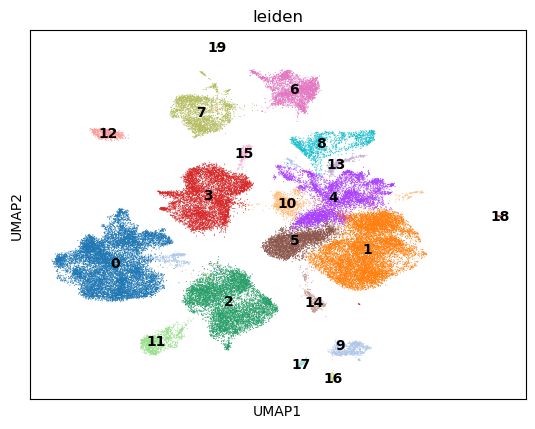

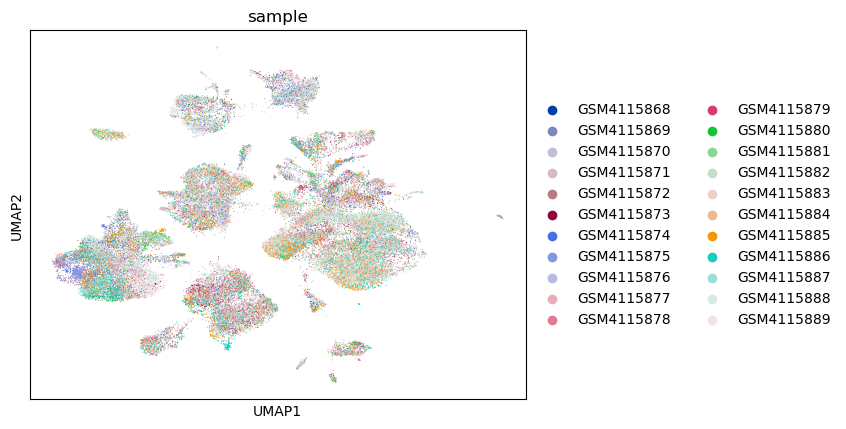

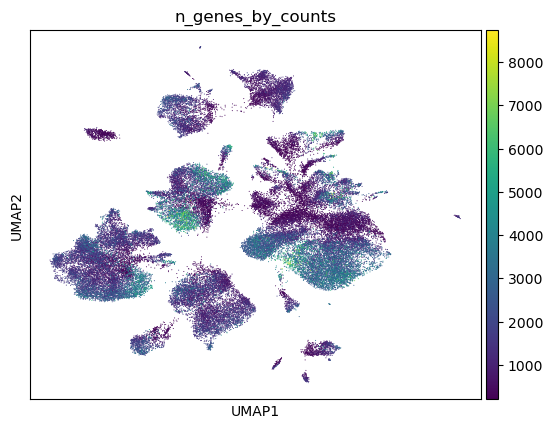

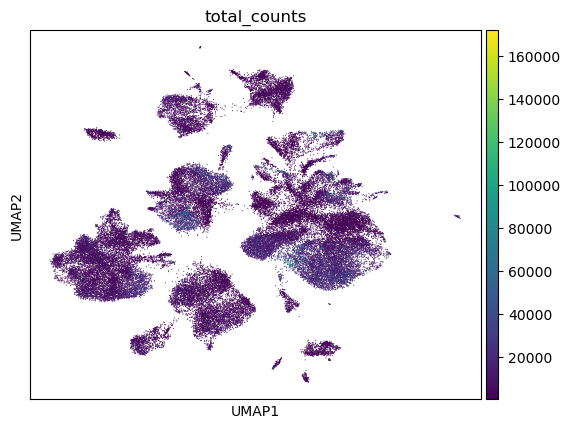

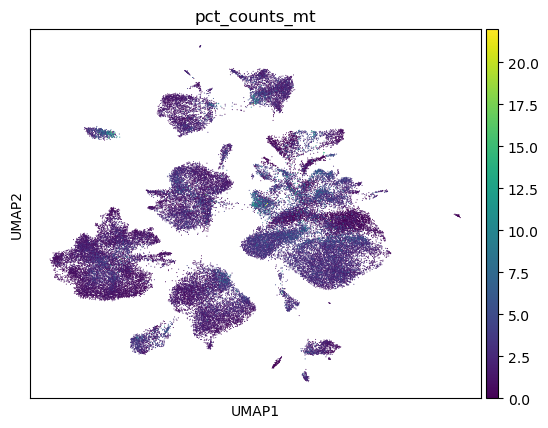

Top clusters by mito%:
    leiden  mito_median
12     12     2.941176
10     10     2.785537
5       5     2.433020
14     14     2.103240
11     11     1.902174
16     16     1.552458
1       1     1.538462
4       4     1.535234
15     15     1.470588
6       6     1.361471

Top clusters by ribo%:
    leiden  ribo_median
4       4    23.414448
1       1    18.960209
5       5    18.155458
19     19    16.941175
6       6    15.123982
8       8    14.595037
13     13    12.814234
3       3    11.423785
14     14    10.660675
2       2    10.091743
computing score 'ECM_score'
    finished: added
    'ECM_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
✅  ECM: scored 6 genes
computing score 'Myo_score'
    finished: added
    'Myo_score', score of gene set (adata.obs).
    98 total control genes are used. (0:00:00)
✅  Myo: scored 4 genes
computing score 'Inflammatory_score'
    finished: added
    'Inflammatory_score', score of gene set (adata.obs)

In [54]:
to_color = [c  for  c  in  ["leiden"         , "pct_counts_mt",
                            "pct_counts_ribo", "n_genes_by_counts"]
               if   c  in  adata.obs.columns]

if  "leiden"  not in  adata.obs.columns  and  "X_umap"  in  adata.obsm:
    # If 'Leiden' 'missing', 'still plot' 'UMAP' with 'QC overlays'.
    pass

if  "X_umap"  in  adata.obsm:
    for  c  in  to_color:
        sc.pl.umap(adata, color=c, save=f"_{c}.png", show=False, vmax="p99")
    # Leiden clusters
    if 'leiden' in adata.obs:
        sc.pl.umap(adata, color=['leiden'], legend_loc='on data', save='_leiden.png')
    # Sample overlay (if present)
    if 'sample' in adata.obs:
        sc.pl.umap(adata, color=['sample'], save='_sample.png')
    # QC overlays (plot if available)
    for k in ['n_genes_by_counts','total_counts','pct_counts_mt']:
        if k in adata.obs:
            sc.pl.umap(adata, color=[k], save=f'_{k}.png')
else:
    print("No UMAP embedding found in adata.obsm['X_umap']; run src/modeling.py or compute UMAP here.")

if  "leiden"  in  adata.obs.columns:
    # 'Ensure' 'leiden' is 'categorical'.
    import pandas as pd

    if not isinstance(adata.obs["leiden"].dtype, pd.CategoricalDtype):
        adata.obs["leiden"] = adata.obs["leiden"].astype("category")

    # Mito%
    mito_df = (
        adata.obs.groupby("leiden", observed=True)[["pct_counts_mt"]]
        .median()
        .reset_index()
        .rename(columns={"pct_counts_mt":"mito_median"})
    )
    mito_top = mito_df.sort_values("mito_median", ascending=False).head(10)
    print("Top clusters by mito%:\n", mito_top)

    # Ribo%
    ribo_df = (
        adata.obs.groupby("leiden", observed=True)[["pct_counts_ribo"]]
        .median()
        .reset_index()
        .rename(columns={"pct_counts_ribo":"ribo_median"})
    )
    ribo_top = ribo_df.sort_values("ribo_median", ascending=False).head(10)
    print("\nTop clusters by ribo%:\n", ribo_top)

    # Save 'tables'.
    mito_df.to_csv(TABDIR / "cluster_mito_medians.csv", index=False)
    ribo_df.to_csv(TABDIR / "cluster_ribo_medians.csv", index=False)
else:
    print("Leiden labels not found; skip per-cluster QC summaries.")

###############################################################################
# Prefer Patch 6 helper for module scoring
ecm  = ["COL1A1", "COL1A2", "COL3A1", "FN1", "POSTN", "THBS2"]
myo  = ["ACTA2", "TAGLN", "MYL9", "CNN1"]
infl = ["IL6", "CCL2", "CXCL14", "HLA-DRA"]

_used = safe_module_score(
    adata,
    {"ECM": ecm, "Myo": myo, "Inflammatory": infl},
    use_raw=False,   # score on normalized/logged X
    verbose=True
)
# print(_used)  # shows which genes were actually used per score

if  "X_umap"  in  adata.obsm:
    sc.pl.umap(
        adata,
        color=["ECM_score", "Myo_score", "Inflammatory_score"],
        save="_module_scores.png",
        show=False,
        vmax="p99",
    )


## 2) Marker inspection & quick DE (optional repeat)

In [56]:
import pandas as pd

# Ensure leiden is categorical
if "leiden" in adata.obs and not isinstance(adata.obs["leiden"].dtype, pd.CategoricalDtype):
    adata.obs["leiden"] = adata.obs["leiden"].astype("category")
# Recompute only if missing or for a different groupby/method
need_rgg = (
    "rank_genes_groups" not in adata.uns
    or adata.uns["rank_genes_groups"].get("params", {}).get("groupby") != "leiden"
    or adata.uns["rank_genes_groups"].get("params", {}).get("method")  != "wilcoxon"
)
if need_rgg and "leiden" in adata.obs:
    try:
        sc.tl.rank_genes_groups(
            adata, groupby="leiden", method="wilcoxon",
            use_raw=False, layer=None, pts=True, tie_correct=True
        )
    except TypeError:
        # Older Scanpy builds don't support pts/tie_correct
        sc.tl.rank_genes_groups(
            adata, groupby="leiden", method="wilcoxon",
            use_raw=False, layer=None
        )
# Export 'tidy DE' (all groups) if available.
if  "rank_genes_groups"  in  adata.uns:
    df = sc.get.rank_genes_groups_df(adata, group=None)
    df.to_csv(TABDIR / "rank_genes_groups_leiden_wilcoxon.csv", index=False)
    print("Saved:", TABDIR / "rank_genes_groups_leiden_wilcoxon.csv")
else:
    print("No rank_genes_groups found; skipping DE export.")


Saved: results/tables/rank_genes_groups_leiden_wilcoxon.csv


## 3) Cell-type annotation scaffold

In [57]:
map_labels = map_labels_auto


## 4) Canonical marker panels (edit to taste)

[panel fibroblast] plotting 5 genes; missing 0


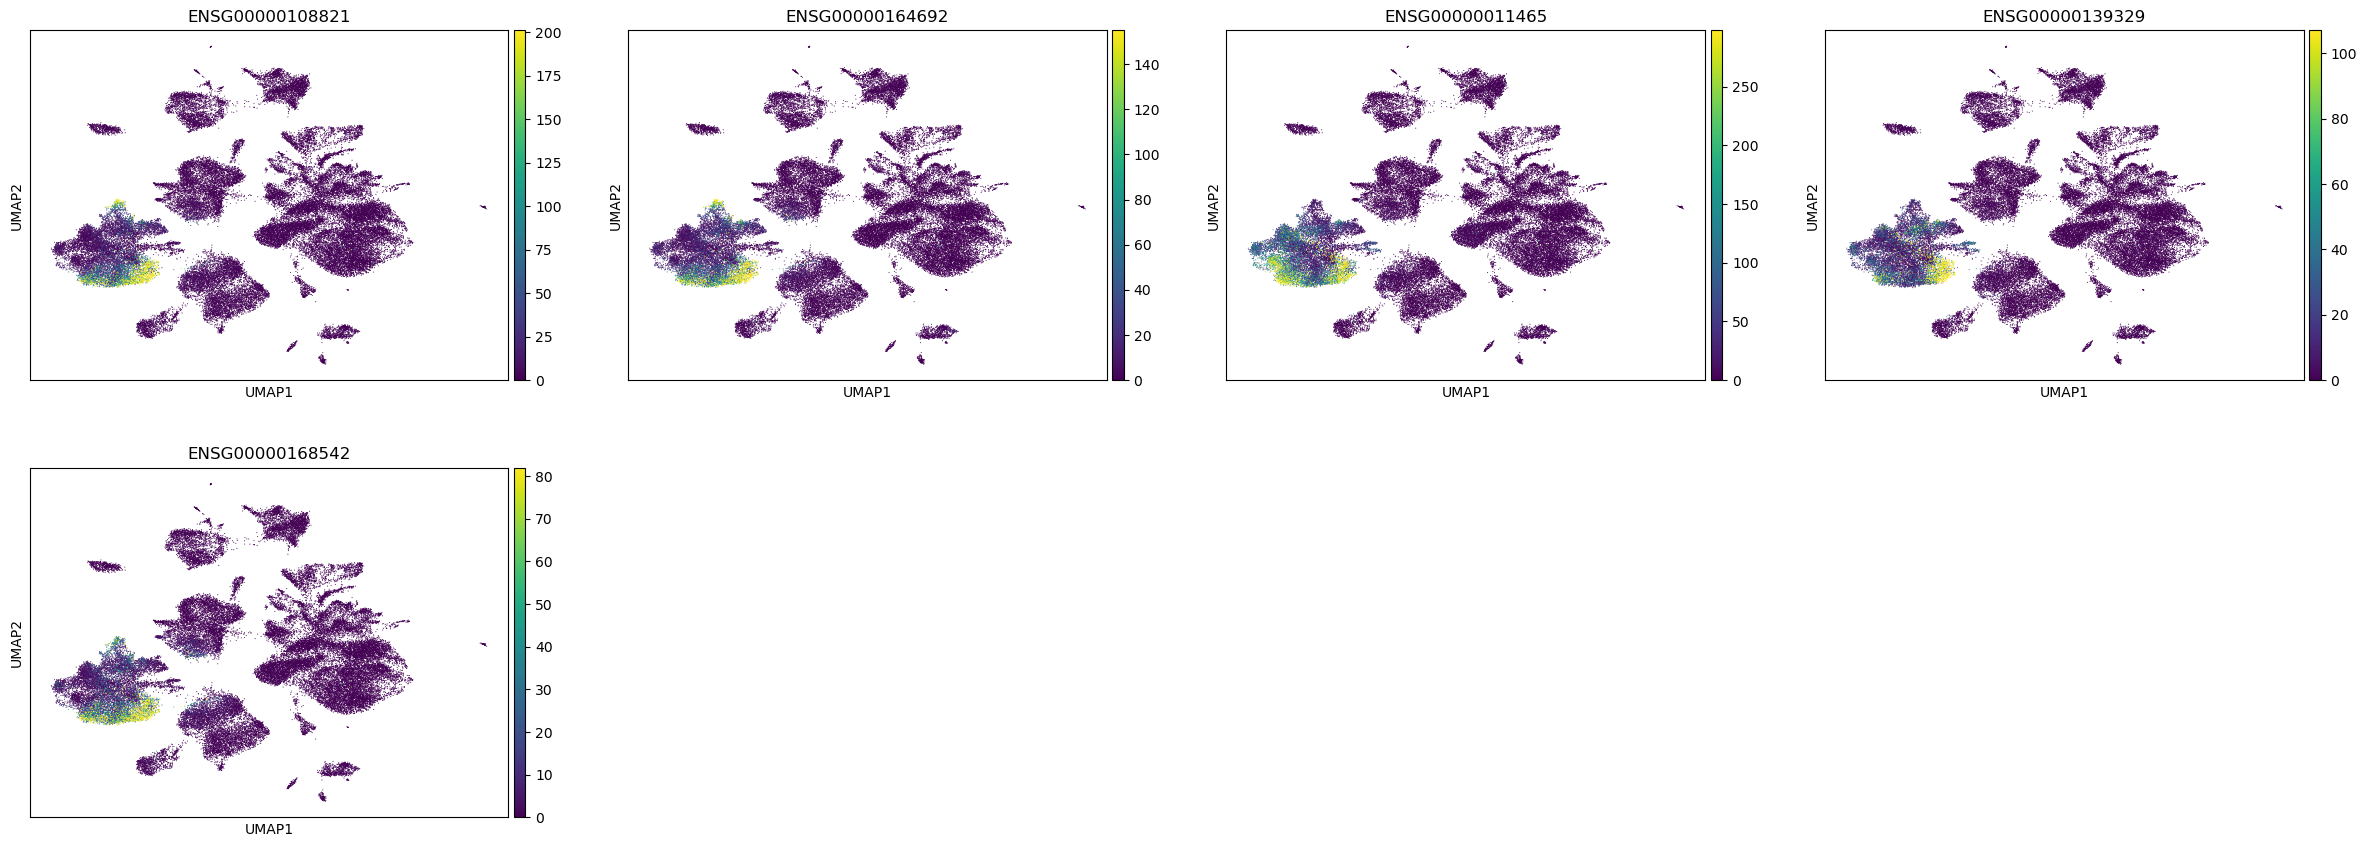

[panel keratinocyte] plotting 4 genes; missing 0


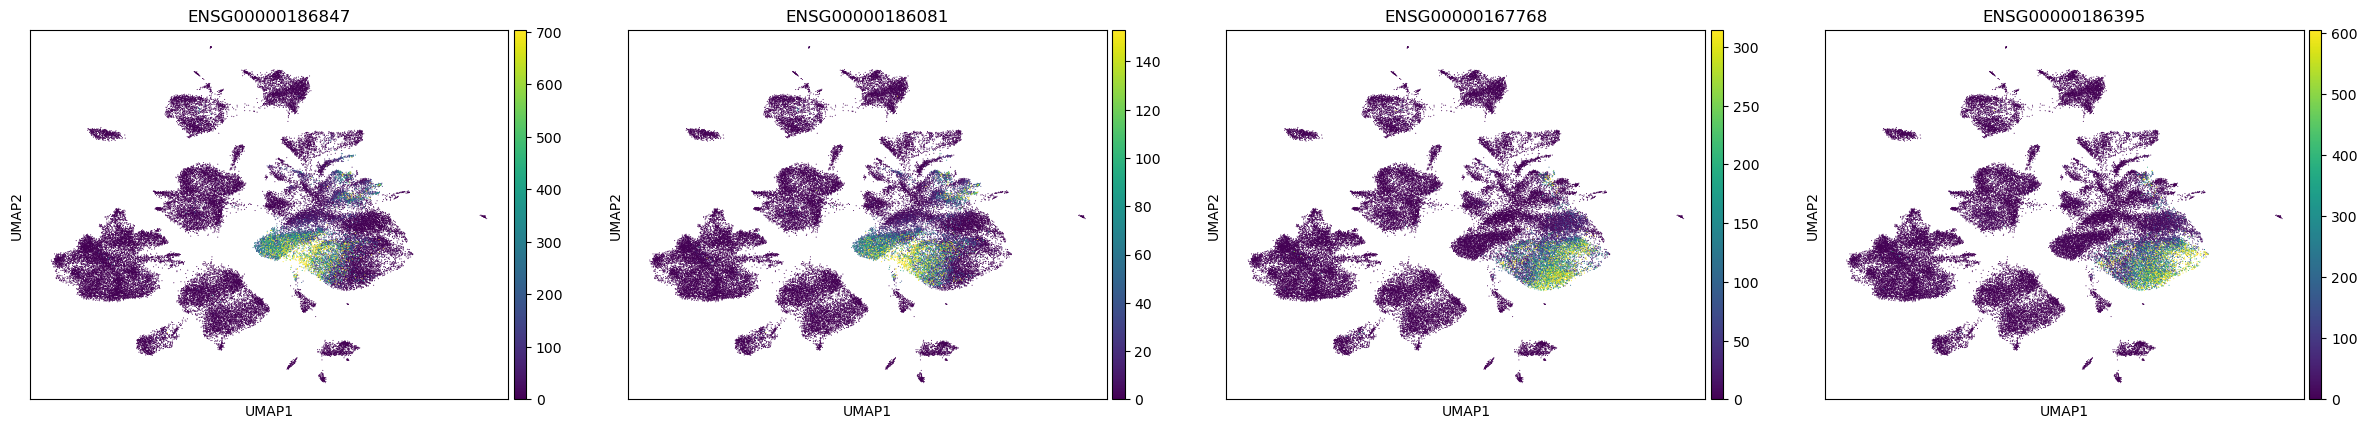

[panel endothelial] plotting 4 genes; missing 0


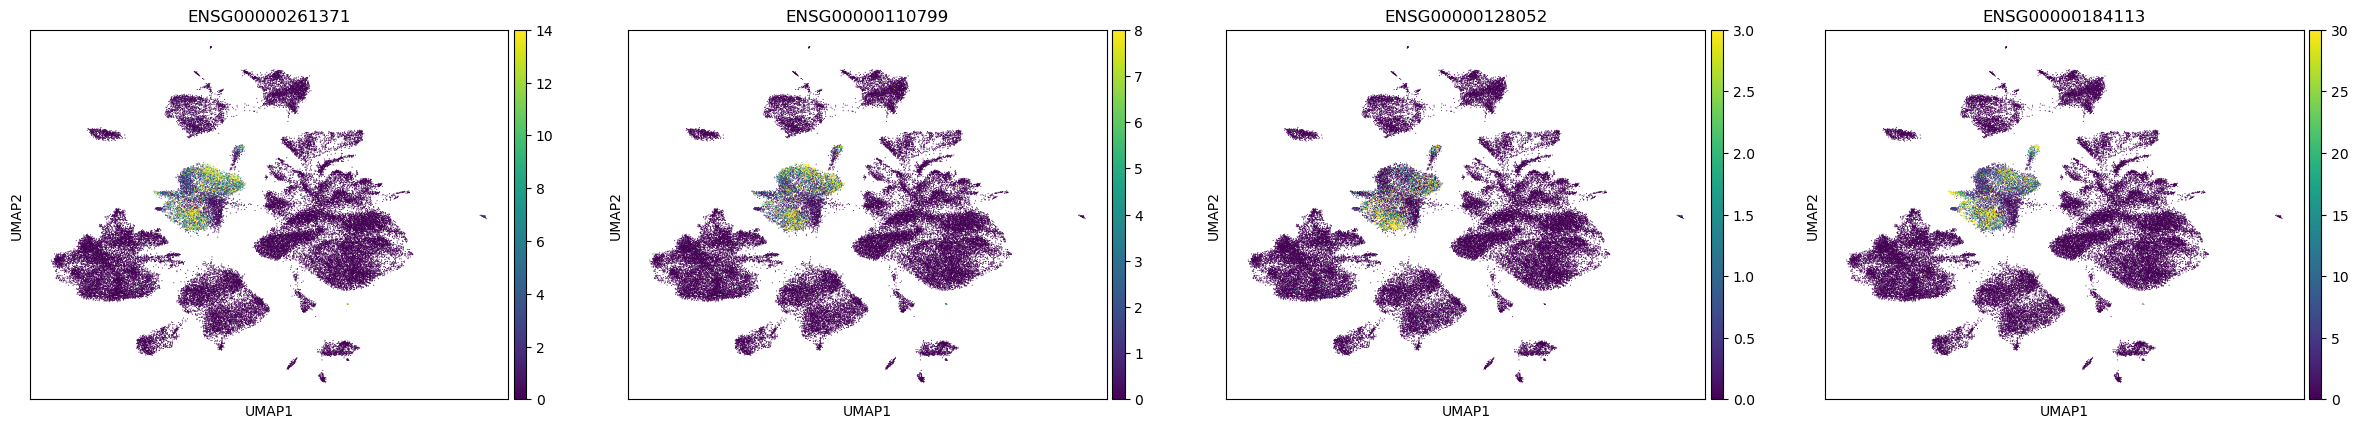

[panel t_cell] plotting 6 genes; missing 0


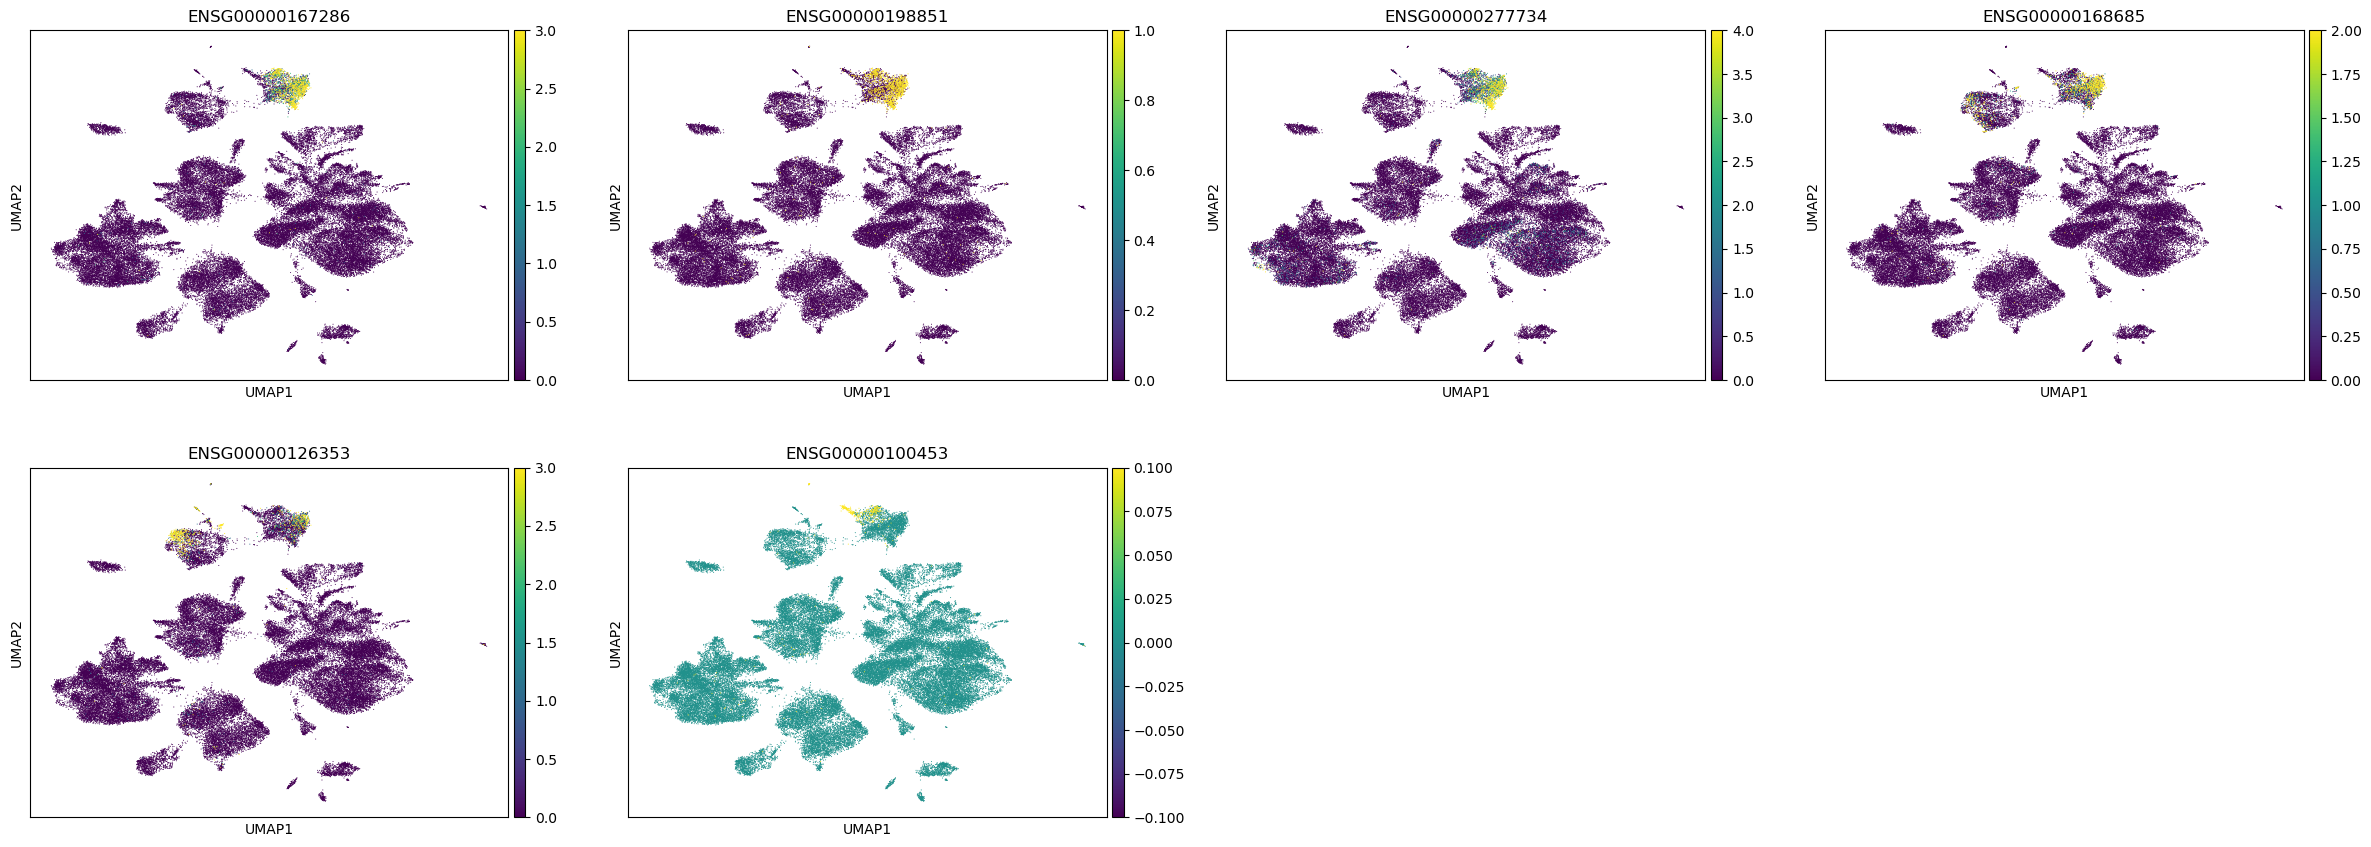

[panel b_cell] plotting 4 genes; missing 0


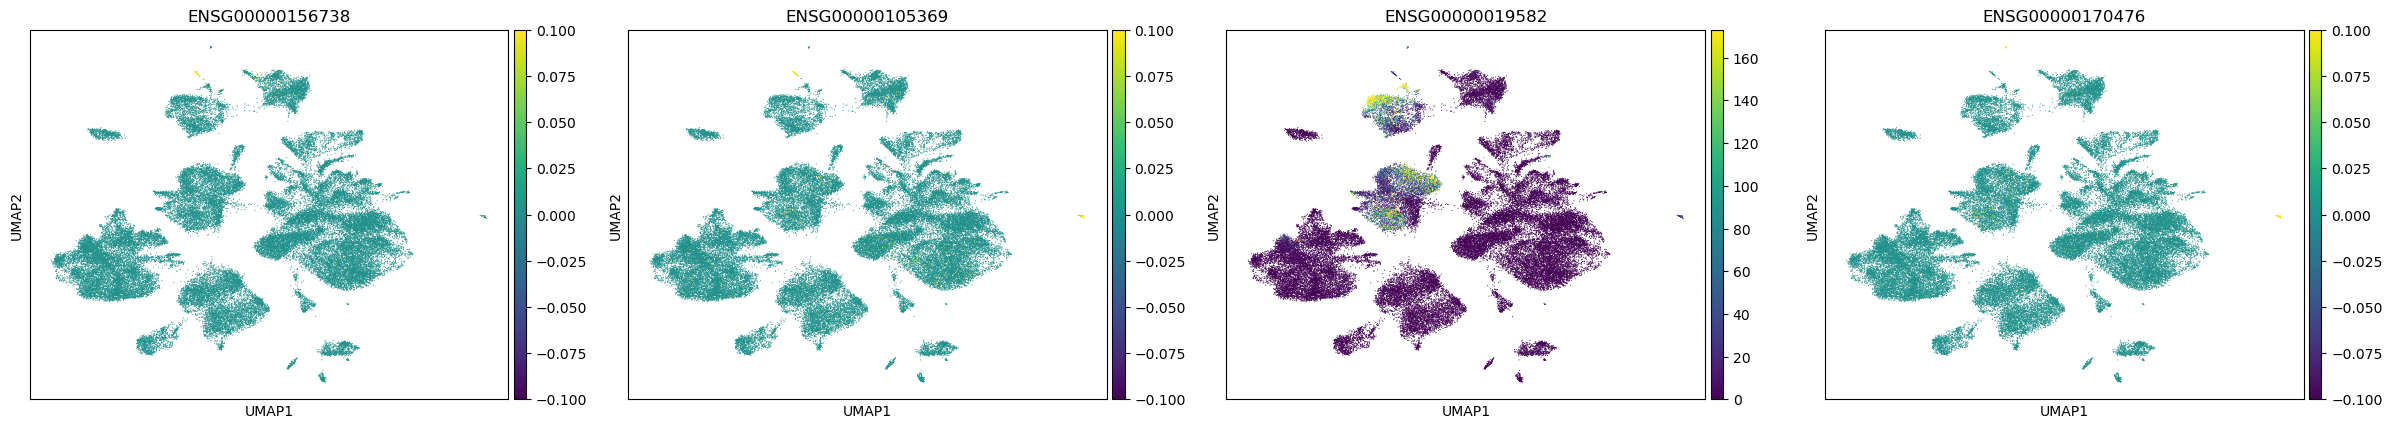

[panel myeloid] plotting 4 genes; missing 1


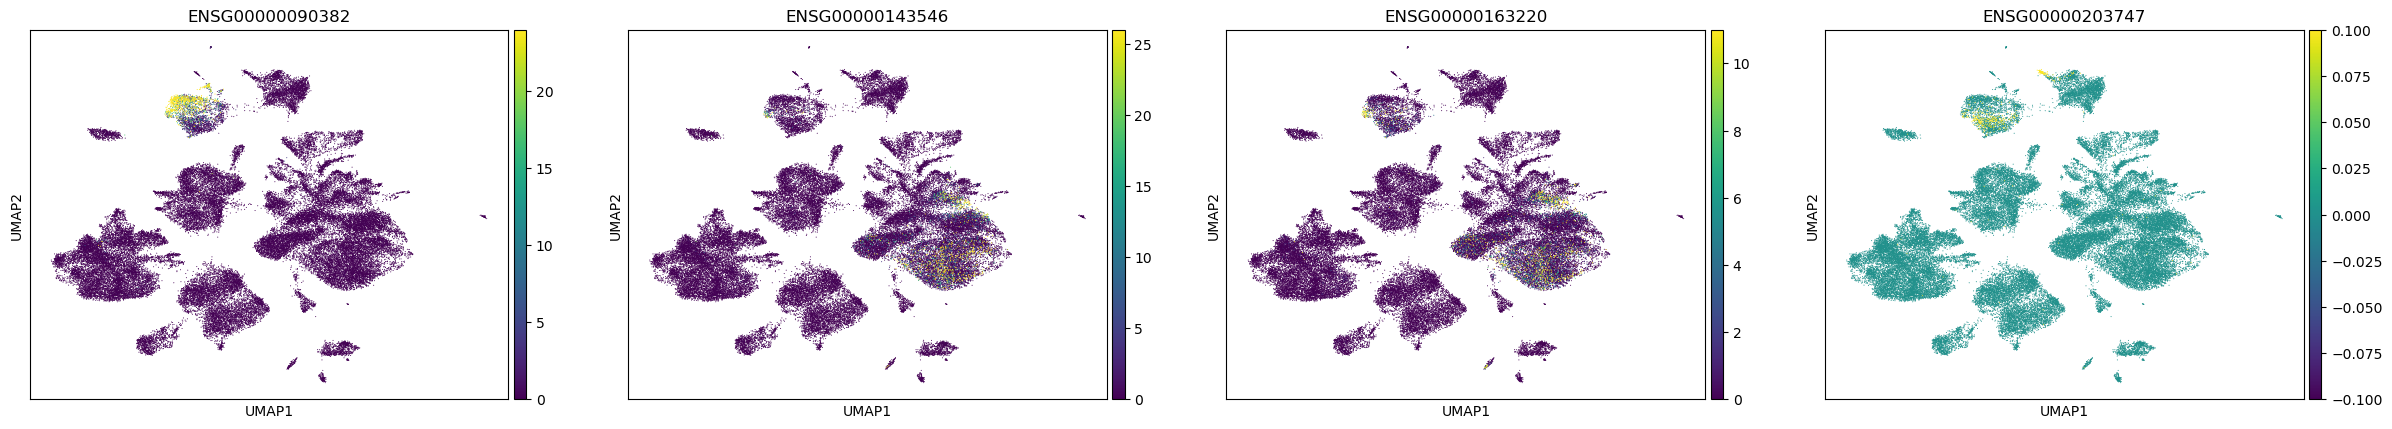

In [60]:
panels = {
    "fibroblast":   ["COL1A1","COL1A2","DCN","LUM","COL3A1"],
    "keratinocyte": ["KRT14","KRT5","KRT1","KRT10"],
    "endothelial":  ["PECAM1","VWF","KDR","CLDN5"],
    "t_cell":       ["CD3D","CD3E","TRAC","IL7R","CCR7","GZMB"],
    "b_cell":       ["MS4A1","CD79A","CD74","MZB1"],
    "myeloid":      ["LYZ","S100A8","S100A9","FCGR3A","LRRK2"],
}

# Build a robust SYMBOL -> var_name lookup without reset_index()
if "gene_symbol" in adata.var.columns:
    var_df = pd.DataFrame({
        "var_name":   adata.var_names.astype(str),
        "gene_symbol": adata.var["gene_symbol"].astype(str),
    }).dropna(subset=["gene_symbol"])
    var_df["KEY"] = var_df["gene_symbol"].str.upper()
    var_df = var_df.drop_duplicates(subset="KEY", keep="first")
    sym2var = dict(zip(var_df["KEY"], var_df["var_name"]))
else:
    # var_names already look like symbols
    sym2var = {g.upper(): g for g in map(str, adata.var_names)}

for name, symbols in panels.items():
    keys    = [s.upper() for s in symbols]
    found   = [sym2var[k] for k in keys if k in sym2var]
    missing = [s for s in symbols if s.upper() not in sym2var]
    if not found:
        print(f"[warn] panel {name}: no genes found; missing {missing[:6]}{'...' if len(missing)>6 else ''}")
        continue
    print(f"[panel {name}] plotting {len(found)} genes; missing {len(missing)}")
    sc.pl.umap(adata, color=found, vmin=0, vmax="p99", cmap="viridis", save=f"_{name}_panel.png")

## 5) Enrichment example (g:Profiler)

In [66]:
import pandas as pd
from gprofiler import GProfiler
from pathlib import Path
import scanpy as sc
 
# Load DE table saved earlier; if missing, rebuild from the current AnnData
de_path = Path("results/tables/rank_genes_groups_leiden_wilcoxon.csv")
if de_path.exists():
    df = pd.read_csv(de_path)
else:
    if "rank_genes_groups" not in adata.uns:
        sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon", use_raw=False)
    df = sc.get.rank_genes_groups_df(adata, group=None)
 
# Decide sort column (fall back if logfoldchanges absent)
sort_col = "logfoldchanges" if "logfoldchanges" in df.columns else "scores"
 
gp = GProfiler(return_dataframe=True)
out_dir = Path("results/tables")
out_dir.mkdir(parents=True, exist_ok=True)

# --- Harmonize & filter for robust queries ---
df = df.copy()
df["group"] = df["group"].astype(str)      # make cluster labels comparable to strings
df = df[df["names"].notna()]               # drop empty gene names

# Optional: keep only significant & upregulated genes for enrichment
df_work = df.copy()
if "pvals_adj" in df_work.columns:
    df_work = df_work[df_work["pvals_adj"] < 0.05]
if sort_col == "logfoldchanges" and "logfoldchanges" in df_work.columns:
    df_work = df_work[df_work["logfoldchanges"] > 0]

for cluster in sorted(df_work["group"].unique(), key=lambda x: int(x) if x.isdigit() else x):
    sub = df_work[df_work["group"] == cluster]
    up = sub.sort_values(sort_col, ascending=False).head(200)["names"].tolist()
    # Fallback without strict filters if filtered set is empty
    if not up:
        sub = df[df["group"] == cluster]
        up = sub.sort_values(sort_col, ascending=False).head(200)["names"].tolist()
    if not up:
        print(f"[skip] leiden {cluster}: no genes found (even without filters)")
        continue

    enr = gp.profile(
        organism="hsapiens",
        query=up,
        sources=["GO:BP", "REAC", "KEGG"],
        user_threshold=0.05,
        significance_threshold_method="fdr",
    )
    out_enr = out_dir / f"enrichment_leiden{cluster}.csv"
    enr.to_csv(out_enr, index=False)
    print("[saved]", out_enr)


[saved] results/tables/enrichment_leiden0.csv
[saved] results/tables/enrichment_leiden1.csv
[saved] results/tables/enrichment_leiden2.csv
[saved] results/tables/enrichment_leiden3.csv
[saved] results/tables/enrichment_leiden4.csv
[saved] results/tables/enrichment_leiden5.csv
[saved] results/tables/enrichment_leiden6.csv
[saved] results/tables/enrichment_leiden7.csv
[saved] results/tables/enrichment_leiden8.csv
[saved] results/tables/enrichment_leiden9.csv
[saved] results/tables/enrichment_leiden10.csv
[saved] results/tables/enrichment_leiden11.csv
[saved] results/tables/enrichment_leiden12.csv
[saved] results/tables/enrichment_leiden13.csv
[saved] results/tables/enrichment_leiden14.csv
[saved] results/tables/enrichment_leiden15.csv
[saved] results/tables/enrichment_leiden16.csv
[saved] results/tables/enrichment_leiden17.csv
[saved] results/tables/enrichment_leiden18.csv
[saved] results/tables/enrichment_leiden19.csv


## 6) Cluster size report

In [67]:
from pathlib import Path
import pandas as pd

# ensure output dir exists
out_dir = Path("results/tables"); out_dir.mkdir(parents=True, exist_ok=True)

# make sure leiden is categorical and sorted numerically if possible
leiden = adata.obs["leiden"]
if not isinstance(leiden.dtype, pd.CategoricalDtype):
    leiden = leiden.astype("category")
try:
    ordered = sorted(leiden.cat.categories, key=lambda x: int(x))
except Exception:
    ordered = list(leiden.cat.categories)  # fall back to current order
leiden = leiden.cat.set_categories(ordered, ordered=True)

# counts and fractions
sizes = leiden.value_counts(sort=False).rename("n_cells").to_frame()
sizes["fraction"] = (sizes["n_cells"] / sizes["n_cells"].sum()).round(6)

# save
sizes_path = out_dir / "cluster_sizes.csv"
sizes.to_csv(sizes_path)
print("[saved]", sizes_path)
sizes

# Per-sample cluster counts (if sample exists)
if "sample" in adata.obs:
    ct = pd.crosstab(adata.obs["sample"], leiden)
    ct_path = out_dir / "cluster_by_sample.csv"
    ct.to_csv(ct_path)
    print("[saved]", ct_path)

# If you already have adata.obs["cell_type"], also summarize by cell type
if "cell_type" in adata.obs:
    ct2 = adata.obs["cell_type"].value_counts().rename("n_cells").to_frame()
    ct2["fraction"] = (ct2["n_cells"] / ct2["n_cells"].sum()).round(6)
    ct2_path = out_dir / "cell_type_sizes.csv"
    ct2.to_csv(ct2_path)
    print("[saved]", ct2_path)


[saved] results/tables/cluster_sizes.csv
[saved] results/tables/cluster_by_sample.csv
[saved] results/tables/cell_type_sizes.csv


# 8) Export key figures

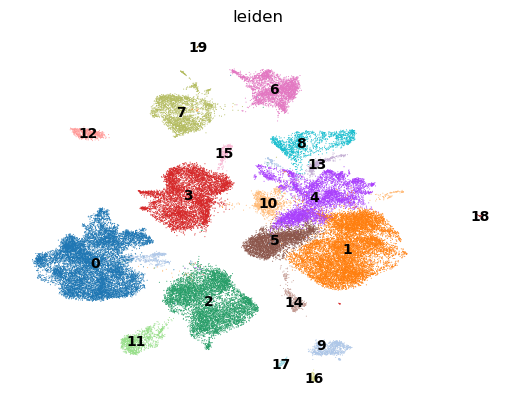

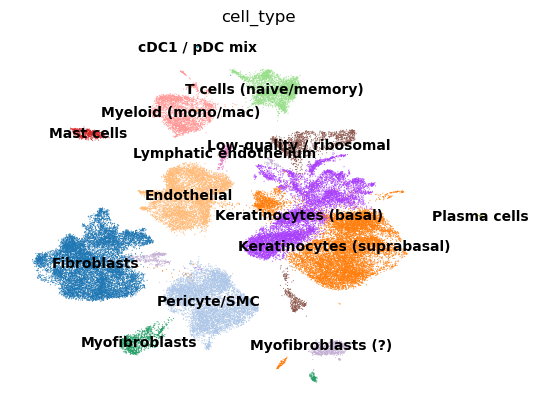

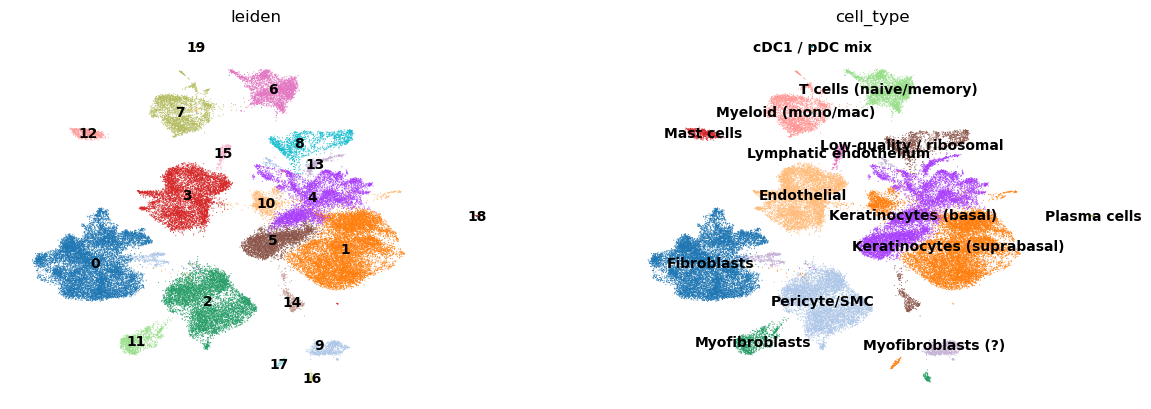

In [69]:
import pandas as pd

# Ensure categorical for nicer legends
if "leiden" in adata.obs and not isinstance(adata.obs["leiden"].dtype, pd.CategoricalDtype):
    adata.obs["leiden"] = adata.obs["leiden"].astype("category")
sc.pl.umap(adata, color=["leiden"], legend_loc="on data", frameon=False, save="_leiden.png")

if "cell_type" in adata.obs:
    if not isinstance(adata.obs["cell_type"].dtype, pd.CategoricalDtype):
        adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")
    sc.pl.umap(adata, color=["cell_type"], legend_loc="on data", frameon=False, save="_celltype.png")
else:
    print("[info] `cell_type` not found; skipping that UMAP.")

# Optional: a combined panel if you want one image with both
if "cell_type" in adata.obs:
    sc.pl.umap(adata, color=["leiden", "cell_type"], legend_loc="on data", frameon=False, save="_leiden_celltype.png")


# 9) Build Mapping Dictionary

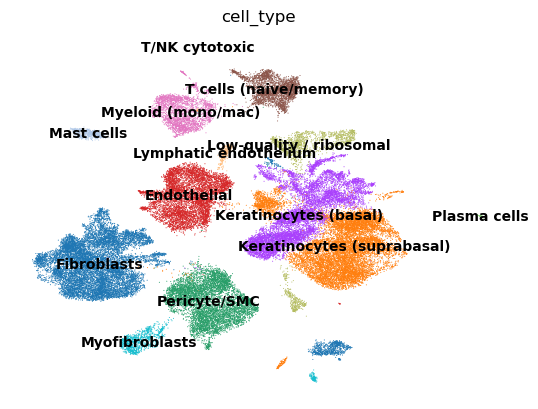

[saved] data/processed/ssc_skin_scvi_annot.h5ad


In [70]:
import pandas as pd

# Final labels aligned with your marker-panel suggestions
# (low-margin clusters flagged in comments for review)
map_labels = {
    "0":  "Fibroblasts",
    "1":  "Keratinocytes (suprabasal)",
    "2":  "Pericyte/SMC",
    "3":  "Endothelial",
    "4":  "Keratinocytes (basal)",
    "5":  "Keratinocytes (basal)",
    "6":  "T cells (naive/memory)",
    "7":  "Myeloid (mono/mac)",
    "8":  "Low-quality / ribosomal",
    "9":  "Fibroblasts",               # low margin – double-check
    "10": "Keratinocytes (suprabasal)",
    "11": "Myofibroblasts",
    "12": "Mast cells",
    "13": "Keratinocytes (basal)",
    "14": "Low-quality / ribosomal",
    "15": "Lymphatic endothelium",
    "16": "Myofibroblasts",            # low margin – double-check
    "17": "Keratinocytes (suprabasal)",
    "18": "Plasma cells",
    "19": "T/NK cytotoxic",            # extremely low margin – double-check
}

leiden_str = adata.obs["leiden"].astype(str)
mapped = leiden_str.map(map_labels)
adata.obs["cell_type"] = mapped.fillna(leiden_str).astype("category")

# Order categories by numeric cluster order, then any leftovers
ordered = pd.unique([map_labels[k] for k in sorted(map_labels, key=int)]).tolist()
leftovers = [c for c in adata.obs["cell_type"].cat.categories if c not in ordered]
adata.obs["cell_type"] = adata.obs["cell_type"].cat.set_categories(ordered + leftovers, ordered=True)

# Warn if any clusters in the data weren't present in map_labels
missing = sorted(set(leiden_str.unique()) - set(map_labels))
if missing:
    print("[info] unmapped Leiden clusters kept as their ID:", missing)

sc.pl.umap(adata, color=["cell_type"], legend_loc="on data", frameon=False, save="_celltype_provisional.png")
adata.write("data/processed/ssc_skin_scvi_annot.h5ad", compression="gzip")
print("[saved] data/processed/ssc_skin_scvi_annot.h5ad")

# 10) Quality Checks to Validate/Adjust

In [71]:
# Inspect top DE for each cluster (already plotted) + overlay key markers (robust to Ensembl var_names)
panels = {
    "Fibroblast_core":  ["COL1A1","COL1A2","COL3A1","DCN","LUM"],
    "Myofibroblast":    ["ACTA2","TAGLN","MYL9","CNN1"],
    "Kerat_basal":      ["KRT14","KRT5","KRT6A","KRT6B"],
    "Kerat_suprabasal": ["KRT1","KRT10","IVL","SPRR1B"],
    "Endothelial":      ["PECAM1","VWF","KDR","CLDN5","CDH5"],
    "Lymph_endothelium":["PROX1","PDPN","LYVE1"],
    "T_naive_mem":      ["CD3D","CD3E","TRAC","IL7R","CCR7"],
    "T_cytotoxic":      ["NKG7","GNLY","PRF1","GZMB"],
    "B_cell":           ["MS4A1","CD79A","CD79B","CD74"],
    "Plasma_cell":      ["MZB1","XBP1","PRDM1","IGHG1"],
    "Myeloid":          ["LYZ","S100A8","S100A9","FCGR3A"],
    "Mast":             ["TPSAB1","CPA3","KIT"],
    "cDC2":             ["CD1C","FCER1A","IRF4"],
    "cDC1":             ["CLEC9A","XCR1","BATF3"],
    "pDC":              ["GZMB","LILRA4","IRF7","JCHAIN"],
    "Pericyte_SMC":     ["RGS5","PDGFRB","MCAM","MYH11","ACTA2"],
}

# Map gene symbols -> actual var_names if adata.var_names are Ensembl
vn_col = adata.var_names.name or "varname"
var_df = adata.var.copy()
var_df[vn_col] = var_df.index
sym2var = None
if "gene_symbol" in var_df.columns:
    sym2var = (
        var_df.loc[var_df["gene_symbol"].notna(), [vn_col, "gene_symbol"]]
              .drop_duplicates("gene_symbol")
              .set_index("gene_symbol")[vn_col]
    )

def to_varnames(glist):
    # dedupe while preserving order
    seen = set(); out = []
    for g in glist:
        v = sym2var.get(g, g) if sym2var is not None else g
        if v in adata.var_names and v not in seen:
            seen.add(v); out.append(v)
    return out

for name, genes in panels.items():
    g_used = to_varnames(genes)
    if not g_used:
        print(f"[skip] {name}: none of {genes} found in var_names.")
        continue
    print(f"[panel] {name}: using {len(g_used)}/{len(genes)} genes")
    sc.pl.umap(
        adata, color=g_used, vmin=0, vmax="p99", cmap="viridis",
        save=f"_{name}.png", show=False
    )
    # Compact per-cluster view too (nice for quick checks)
    try:
        sc.pl.dotplot(
            adata, var_names=g_used, groupby="leiden", standard_scale="var",
            save=f"_{name}_dot.png", show=False
        )
    except Exception as e:
        print(f"[warn] dotplot {name} failed: {e}")

[panel] Fibroblast_core: using 5/5 genes
[panel] Myofibroblast: using 4/4 genes
[panel] Kerat_basal: using 4/4 genes
[panel] Kerat_suprabasal: using 4/4 genes
[panel] Endothelial: using 5/5 genes
[panel] Lymph_endothelium: using 3/3 genes
[panel] T_naive_mem: using 5/5 genes
[panel] T_cytotoxic: using 4/4 genes
[panel] B_cell: using 4/4 genes
[panel] Plasma_cell: using 3/4 genes
[panel] Myeloid: using 4/4 genes
[panel] Mast: using 3/3 genes
[panel] cDC2: using 3/3 genes
[panel] cDC1: using 1/3 genes
[panel] pDC: using 2/4 genes
[panel] Pericyte_SMC: using 5/5 genes


# 11) Handy helpers (spot QC clusters quickly)

In [73]:
import numpy as np
import scipy.sparse as sp

def gene_set_mean(adata, genes, *, case_insensitive=True, fill_value=np.nan):
    vn = adata.var_names.astype(str)
    if case_insensitive:
        vn_upper = vn.str.upper()
        genes_upper = {g.upper() for g in map(str, genes)}
        mask = vn_upper.isin(genes_upper)
    else:
        mask = vn.isin(list(map(str, genes)))

    if not mask.any():
        return np.full(adata.n_obs, fill_value, dtype=float)

    Xr = adata[:, vn[mask]].X
    m = Xr.mean(axis=1)
    if hasattr(m, "A1"):
        m = m.A1
    else:
        m = np.asarray(m).ravel()
    return m

import numpy as np
import pandas as pd
import scanpy as sc

def _pick_symbol_series(a):
    # Try common columns for gene symbols; fall back to var_names
    for c in ["gene_symbol","gene_symbols","symbol","symbols","SYMBOL",
              "gene_name","gene_names","feature_name","features"]:
        if c in a.var.columns:
            return a.var[c].astype(str)
    return a.var_names.astype(str)

# Use a base matrix that still has *all* genes and preferably raw counts
base = adata.raw.to_adata() if adata.raw is not None else adata
mt_layer = "counts" if "counts" in getattr(base, "layers", {}) else None  # use counts layer if present

# ---------- Mito percent ----------
names = _pick_symbol_series(base)
names_u = names.str.upper()
base.var["mt"] = names_u.str.startswith(("MT-","MT.","MT_"))  # robust to separators

# Compute QC on base (raw/counts if available)
sc.pp.calculate_qc_metrics(base, qc_vars=["mt"], layer=mt_layer, inplace=True)

# Bring mito% back to your working object (same obs index)
adata.obs["pct_counts_mt"] = base.obs["pct_counts_mt"].values

# ---------- Ribosomal score+ percent ----------
ribo_mask = names_u.str.startswith(("RPS","RPL")).to_numpy()
if not ribo_mask.any():
    print("⚠️ No ribosomal genes found in the base matrix (likely HVG subsetting or non-symbol IDs).")
    adata.obs["ribo_score"] = np.nan
    adata.obs["pct_counts_ribo"] = np.nan
else:
    # use counts layer if present; otherwise current X
    Xbase = base.layers["counts"] if "counts" in getattr(base, "layers", {}) else base.X
    Xr = Xbase[:, ribo_mask]
    # mean expression across ribosomal genes per cell
    if sp.issparse(Xr):
        m = Xr.mean(axis=1).A1
    else:
        m = Xr.mean(axis=1)
    adata.obs["ribo_score"] = np.asarray(m).ravel()
    # percent of counts in ribosomal genes
    if sp.issparse(Xbase):
        ribo_sum = Xr.sum(axis=1).A1
        total    = Xbase.sum(axis=1).A1
    else:
        ribo_sum = Xr.sum(axis=1)
        total    = Xbase.sum(axis=1)
    ribo_sum = np.asarray(ribo_sum).ravel()
    total    = np.asarray(total).ravel()
    with np.errstate(divide="ignore", invalid="ignore"):
        frac = np.where(total > 0, ribo_sum / total, np.nan).astype(np.float32)
    adata.obs["pct_counts_ribo"] = (100.0 * frac).astype(np.float32)

# ---------- Reporting ----------
if "leiden" in adata.obs:
    print("Top clusters by mito%:")
    print(
        adata.obs.groupby("leiden")["pct_counts_mt"]
        .median()
        .sort_values(ascending=False)
        .head(5)
    )
    print("Top clusters by ribosomal score:")
    print(adata.obs.groupby("leiden", observed=True)["ribo_score"]
              .median()
              .sort_values(ascending=False)
              .head(5))
else:
    print("ℹ️ 'leiden' not found; skipping cluster summaries.")

mt_frac = adata.obs.get("pct_counts_mt", None)
if mt_frac is not None and "leiden" in adata.obs:
    THRESH = 12.0
    med = (adata.obs.groupby("leiden", observed=True)["pct_counts_mt"]
                 .median()
                 .sort_values(ascending=False))
    print(f"Clusters with high mito (median > {THRESH}%):")
    print(med[med > THRESH].head(10))


Top clusters by mito%:
leiden
12    2.941176
10    2.785537
5     2.433020
14    2.103240
11    1.902174
Name: pct_counts_mt, dtype: float32
Top clusters by ribosomal score:
leiden
5     22.625000
1     20.291668
19    12.416668
3      9.250000
18     9.125000
Name: ribo_score, dtype: float32
Clusters with high mito (median > 12.0%):
Series([], Name: pct_counts_mt, dtype: float32)


In [75]:
import numpy as np
import pandas as pd
import scanpy as sc

# Use the most complete matrix you have
base = adata.raw.to_adata() if adata.raw is not None else adata

# Prefer gene symbols; fall back to var_names
names = (base.var["gene_symbol"].astype(str)
         if "gene_symbol" in base.var.columns
         else base.var_names.astype(str))
names_u = names.str.upper()

# Robust flags
mt_mask   = names_u.str.startswith(("MT-","MT.","MT_"))
ribo_mask = names_u.str.startswith(("RPS","RPL"))

# Count with the robust masks (on the base)
mt_n   = int(mt_mask.sum())
ribo_n = int(ribo_mask.sum())
print(f"MT genes flagged (base): {mt_n} | Ribosomal genes available (base): {ribo_n}")

# (Re)compute mito% on base, then copy back
base.var["mt"] = mt_mask.values
sc.pp.calculate_qc_metrics(base, qc_vars=["mt"], layer=("counts" if "counts" in base.layers else None), inplace=True)
adata.obs["pct_counts_mt"] = base.obs["pct_counts_mt"].values

# (Re)compute % ribosomal on base using counts if you have them; else X
import scipy.sparse as sp
X = base.layers["counts"] if "counts" in base.layers else base.X
if sp.issparse(X):
    ribo_sum = X[:, ribo_mask.values].sum(axis=1).A1
    total    = X.sum(axis=1).A1
else:
    ribo_sum = X[:, ribo_mask.values].sum(axis=1)
    total    = X.sum(axis=1)
with np.errstate(divide="ignore", invalid="ignore"):
    frac = np.where(total > 0, ribo_sum / total, np.nan).astype("float32")

adata.obs["pct_counts_ribo"] = 100.0 * frac  # percent, more interpretable than a mean


MT genes flagged (base): 2 | Ribosomal genes available (base): 12


# 11B) Recompute mito/ribo metrics on the current object (works if symbols available)

In [77]:
import numpy as np
import pandas as pd
import scanpy as sc

# Work on a base matrix that has full genes and (ideally) counts
base = adata.raw.to_adata() if adata.raw is not None else adata.copy()
layer_for_qc = "counts" if "counts" in getattr(base, "layers", {}) else None

# Prefer gene symbols; fill "nan" with var_names
if "gene_symbol" in base.var.columns:
    names = base.var["gene_symbol"].astype(str)
    names = names.where(names.str.lower() != "nan", other=base.var_names.astype(str))
else:
    names = base.var_names.astype(str)
names_u = names.str.upper()

# Robust MT detection by normalizing punctuation
MT_CANON = {
    "MT-CO1","MT-CO2","MT-CO3","MT-CYB","MT-ND1","MT-ND2","MT-ND3","MT-ND4","MT-ND4L",
    "MT-ND5","MT-ND6","MT-ATP6","MT-ATP8","MT-RNR1","MT-RNR2"
}
norm = names_u.str.replace(r"[^A-Z0-9]", "", regex=True)
mt_norm_set = {g.replace("-", "").replace("_", "").replace(".", "") for g in MT_CANON}
base.var["mt"] = norm.isin(mt_norm_set)

# Ribosomal flags (RPL*/RPS*)
base.var["ribo"] = names_u.str.startswith(("RPL","RPS"))

# Compute QC on the base (uses counts layer if present)
sc.pp.calculate_qc_metrics(base, qc_vars=["mt","ribo"], layer=layer_for_qc, percent_top=None, inplace=True)

# Copy metrics back to the working object
adata.obs["pct_counts_mt"]   = base.obs["pct_counts_mt"].astype("float32").values
adata.obs["pct_counts_ribo"] = base.obs["pct_counts_ribo"].astype("float32").values

# Quick summaries
print(f"MT genes flagged (base): {int(base.var['mt'].sum())} | Ribosomal genes (base): {int(base.var['ribo'].sum())}")
print(adata.obs[["pct_counts_mt","pct_counts_ribo"]].describe())
if "leiden" in adata.obs:
    print("\nCluster medians (top by mito):")
    print(
        adata.obs.groupby("leiden")[["pct_counts_mt","pct_counts_ribo"]]
        .median()
        .sort_values("pct_counts_mt", ascending=False)
        .head(5)
    )


MT genes flagged (base): 2 | Ribosomal genes (base): 12
       pct_counts_mt  pct_counts_ribo
count   56147.000000     56147.000000
mean        1.626801        13.747843
std         1.597303         8.701246
min         0.000000         0.000000
25%         0.552595         7.352942
50%         1.226693        11.773870
75%         2.238806        18.525324
max        22.000000        78.534027

Cluster medians (top by mito):
        pct_counts_mt  pct_counts_ribo
leiden                                
12           2.941176         9.433963
10           2.785537         4.724410
5            2.433020        18.155458
14           2.103240        10.660675
11           1.902174         5.978261


In [78]:
dups = adata.obs.columns[adata.obs.columns.duplicated()].unique().tolist()
if dups:
    print("Duplicate column names:", dups)
    for col in dups:
        cols = [c for c in adata.obs.columns if c == col]
        same = all(adata.obs[cols[0]].equals(adata.obs[c]) for c in cols[1:])
        print(f"  {col}: {len(cols)} copies — {'identical' if same else 'DIFFERENT VALUES'}")


In [79]:
import pandas as pd

need = [k for k in ["pct_counts_mt", "pct_counts_ribo"] if k not in adata.obs]
if need:
    print(f"⚠️ Missing columns in adata.obs: {need} — compute QC first or skip this cell.")

# Ensure leiden is categorical (avoids pandas warnings and keeps empty groups out)
if "leiden" in adata.obs and not isinstance(adata.obs["leiden"].dtype, pd.CategoricalDtype):
    adata.obs["leiden"] = adata.obs["leiden"].astype("category")

# --- mito % ---
if "pct_counts_mt" in adata.obs:
    mito_df = (
        adata.obs.groupby("leiden", observed=True)[["pct_counts_mt"]]
        .median()
        .reset_index()
        .sort_values("pct_counts_mt", ascending=False)
    )
    print("Top clusters by mito%:")
    print(mito_df.head(5))
    mito_df.to_csv(TABDIR / "cluster_mito_medians.csv", index=False)

# --- ribo % ---
if "pct_counts_ribo" in adata.obs:
    ribo_df = (
        adata.obs.groupby("leiden", observed=True)[["pct_counts_ribo"]]
        .median()
        .reset_index()
        .sort_values("pct_counts_ribo", ascending=False)
    )
    print("\nTop clusters by ribo%:")
    print(ribo_df.head(5))
    ribo_df.to_csv(TABDIR / "cluster_ribo_medians.csv", index=False)


Top clusters by mito%:
   leiden  pct_counts_mt
12     12       2.941176
10     10       2.785537
5       5       2.433020
14     14       2.103240
11     11       1.902174

Top clusters by ribo%:
   leiden  pct_counts_ribo
4       4        23.414448
1       1        18.960209
5       5        18.155458
19     19        16.941175
6       6        15.123982


In [80]:
import pandas as pd

s = "GSM4115868"

# sanity checks
need = [c for c in ["sample", "cell_type"] if c not in adata.obs]
if need:
    raise KeyError(f"Missing columns in adata.obs: {need}")

# be robust to dtype (some pipelines keep 'sample' as category)
sample_str = adata.obs["sample"].astype(str)
if s not in set(sample_str.unique()):
    raise ValueError(f"Sample '{s}' not found. Available examples: {sorted(sample_str.unique())[:10]}")

subset = adata[sample_str == s].copy()

# counts and proportions
counts = subset.obs["cell_type"].value_counts().rename("n_cells")
props  = subset.obs["cell_type"].value_counts(normalize=True).rename("proportion")
summary = pd.concat([counts, props], axis=1).sort_values("proportion", ascending=False)

print(summary)
print(f"\nFibroblast fraction in {s}: {props.get('Fibroblasts', 0):.2%}")

ctab = (
    adata.obs.groupby(["sample", "cell_type"]).size()
    .rename("n_cells").reset_index()
)
ctab["proportion"] = (
    ctab["n_cells"] / ctab.groupby("sample")["n_cells"].transform("sum")
)
# pivot to a neat samples × cell_type table of proportions
prop_table = ctab.pivot(index="sample", columns="cell_type", values="proportion").fillna(0)
prop_table.head()



                            n_cells  proportion
cell_type                                      
Fibroblasts                     330    0.268949
Keratinocytes (basal)           327    0.266504
Keratinocytes (suprabasal)      168    0.136919
Pericyte/SMC                    100    0.081500
Endothelial                      99    0.080685
T cells (naive/memory)           78    0.063570
Myeloid (mono/mac)               55    0.044825
Low-quality / ribosomal          33    0.026895
Myofibroblasts                   20    0.016300
Lymphatic endothelium            15    0.012225
Mast cells                        2    0.001630

Fibroblast fraction in GSM4115868: 26.89%


cell_type   Fibroblasts  Keratinocytes (suprabasal)  Pericyte/SMC  \
sample                                                              
GSM4115868     0.268949                    0.136919      0.081500   
GSM4115869     0.098802                    0.190120      0.165419   
GSM4115870     0.220105                    0.053796      0.142638   
GSM4115871     0.268783                    0.137831      0.185185   
GSM4115872     0.328620                    0.225926      0.074747   

cell_type   Endothelial  Keratinocytes (basal)  T cells (naive/memory)  \
sample                                                                   
GSM4115868     0.080685               0.266504                0.063570   
GSM4115869     0.128743               0.352545                0.012725   
GSM4115870     0.245619               0.189671                0.018137   
GSM4115871     0.100529               0.208730                0.008730   
GSM4115872     0.047475               0.148148                0.052862   

cell_type   Myeloid (mono/mac)  Low-quality / ribosomal  Myofibroblasts  \
sample                                                                    
GSM4115868            0.044825                 0.026895        0.016300   
GSM4115869            0.009731                 0.029940        0.006737   
GSM4115870            0.017522                 0.060252        0.043652   
GSM4115871            0.041270                 0.027513        0.007407   
GSM4115872            0.056566                 0.022222        0.035354   

cell_type   Mast cells  Lymphatic endothelium  Plasma cells  T/NK cytotoxic  
sample                                                                       
GSM4115868    0.001630               0.012225           0.0        0.000000  
GSM4115869    0.002246               0.002994           0.0        0.000000  
GSM4115870    0.002459               0.006148           0.0        0.000000  
GSM4115871    0.012434               0.001058           0.0        0.000529  
GSM4115872    0.003704               0.004377           0.0        0.000000


Cluster sizes:
leiden
0     11572
1     10456
2      6624
3      6381
4      5238
5      3534
6      2852
7      2657
8      1476
9      1222
10     1156
11     1063
12      557
13      412
14      384
15      275
16      118
17       97
18       54
19       19
Name: count, dtype: int64

QC medians by cluster (top 5):

pct_counts_mt:
 leiden
12    2.941176
10    2.785537
5     2.433020
14    2.103240
11    1.902174
Name: pct_counts_mt, dtype: float32

pct_counts_ribo:
 leiden
4     23.414448
1     18.960209
5     18.155458
19    16.941175
6     15.123982
Name: pct_counts_ribo, dtype: float32


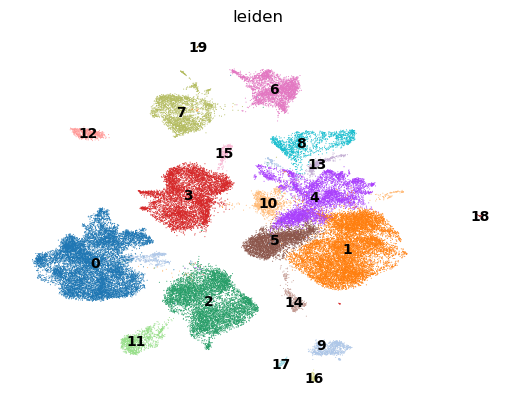

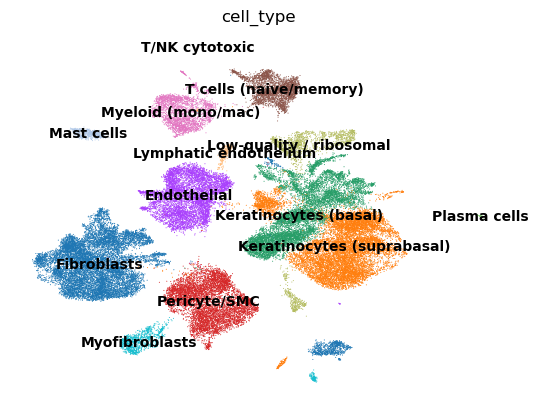

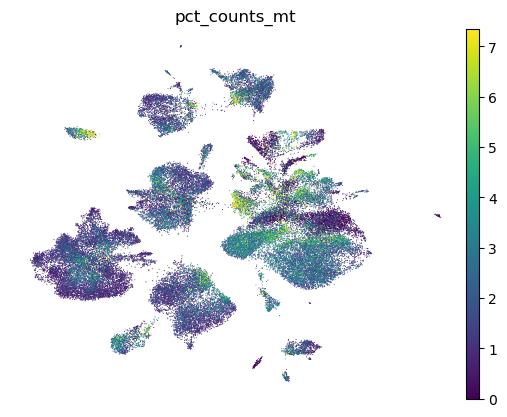

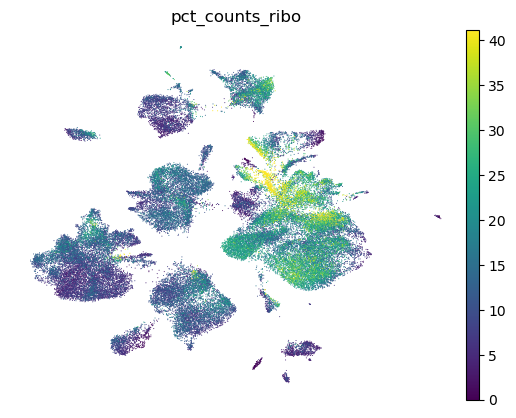

[saved] data/processed/ssc_skin_scvi_annot_curated.h5ad
[saved] results/tables/cluster_sizes.csv, results/tables/cluster_qc_medians.csv


In [83]:
import numpy as np, pandas as pd, scanpy as sc
from pathlib import Path

# 1) Required columns and objects
must_obs = ["leiden", "cell_type"]
missing = [c for c in must_obs if c not in adata.obs]
assert not missing, f"Missing required obs columns: {missing}"

# 2) Ensure categorical & unique/ordered categories
for c in ["leiden","cell_type"]:
    if not isinstance(adata.obs[c].dtype, pd.CategoricalDtype):
        adata.obs[c] = adata.obs[c].astype("category")
    # drop duplicate categories if any and order by frequency
    counts = adata.obs[c].value_counts()
    ordered = counts.index.tolist()
    adata.obs[c] = adata.obs[c].cat.set_categories(ordered, ordered=True)

# 3) Quick QC presence checks (computed earlier)
for k in ["pct_counts_mt","pct_counts_ribo","ribo_score"]:
    if k not in adata.obs: 
        print(f"⚠️ {k} not present (ok if intentionally omitted).")

# 4) Quick summaries
print("\nCluster sizes:")
print(adata.obs["leiden"].value_counts().sort_index())

print("\nQC medians by cluster (top 5):")
for col in ["pct_counts_mt","pct_counts_ribo"]:
    if col in adata.obs:
        m = (adata.obs.groupby("leiden")[col]
             .median()
             .sort_values(ascending=False)
             .head(5))
        print(f"\n{col}:\n", m)

# 5) Plots (if UMAP is present)
if "X_umap" in adata.obsm:
    sc.pl.umap(adata, color=["leiden"], legend_loc="on data", frameon=False, save="_leiden_final.png")
    sc.pl.umap(adata, color=["cell_type"], legend_loc="on data", frameon=False, save="_celltype_final.png")
    for q in ["pct_counts_mt","pct_counts_ribo"]:
        if q in adata.obs:
            sc.pl.umap(adata, color=[q], frameon=False, vmax="p99", save=f"_{q}_final.png")
else:
    print("ℹ️ No UMAP embedding found; skipping plots.")

# 6) Save final curated object & a couple of helper tables
out_h5ad = Path("data/processed/ssc_skin_scvi_annot_curated.h5ad")
adata.write(out_h5ad, compression="gzip")
print("[saved]", out_h5ad)

# cluster sizes & QC medians
sizes = adata.obs["leiden"].value_counts().sort_index().rename("n_cells").to_frame()
sizes.to_csv("results/tables/cluster_sizes.csv")
if {"pct_counts_mt","pct_counts_ribo"}.issubset(adata.obs.columns):
    qc = (adata.obs.groupby("leiden")[["pct_counts_mt","pct_counts_ribo"]]
          .median().reset_index())
    qc.to_csv("results/tables/cluster_qc_medians.csv", index=False)
    print("[saved] results/tables/cluster_sizes.csv, results/tables/cluster_qc_medians.csv")
else:
    print("[saved] results/tables/cluster_sizes.csv")


In [85]:
# === Save final map_labels into .uns for provenance ===
from pathlib import Path
from datetime import datetime
import pandas as pd

# If you already have `map_labels_final`, we’ll use it.
# Otherwise, reconstruct a best-effort map from current annotations.
if "map_labels_final" not in locals():
    le = adata.obs["leiden"].astype(str)
    ct = adata.obs["cell_type"].astype(str)
    # mode label per cluster
    map_labels_final = (ct.groupby(le)
                          .agg(lambda s: s.value_counts().idxmax())
                          .to_dict())

# Normalize keys/values to strings
map_labels_final = {str(k): str(v) for k, v in map_labels_final.items()}

# Stash in .uns with a little provenance
prov = adata.uns.setdefault("labeling_provenance", {})
prov["cell_type_map"] = map_labels_final
prov["cell_type_map_order"] = (
    list(adata.obs["cell_type"].cat.categories)

    if isinstance(adata.obs["cell_type"].dtype, pd.CategoricalDtype)
    else sorted(map(str, adata.obs["cell_type"].unique()))
)
prov["timestamp"] = datetime.now().isoformat(timespec="seconds")
prov["notes"] = "Curated from marker panels + DE + ambiguity review."

# Also write a CSV for quick inspection
Path("results/tables").mkdir(parents=True, exist_ok=True)
pd.Series(map_labels_final, name="cell_type").rename_axis("leiden").to_csv(
    "results/tables/cell_type_map.csv"
)

# Save the H5AD with the embedded mapping
out = Path("data/processed/ssc_skin_scvi_annot_curated.h5ad")
adata.write(out, compression="gzip")
print("[saved]", out)
print("[saved] results/tables/cell_type_map.csv")


[saved] data/processed/ssc_skin_scvi_annot_curated.h5ad
[saved] results/tables/cell_type_map.csv
